# Table of contents
<br>
<font size=3>
    
* [Settings](#0.-Settings)
    * [Librerie](#0.1-Librerie)
    * [Data Load](#0.2-Data-load)
* [Pattern](#1.-Pattern)
    * [Problema nel Tagging](#1.1-Problema-nel-Tagging)
    * [Differenze nei Tagger](#1.2-Differenze-nei-Tagger)
    * [Algoritmo per i Pattern](#1.3-Algoritmo-per-i-Pattern)
    * [Save and Load](#1.4-Save-and-Load)
    * [Pattern Rilevanti](#1.5-Pattern-Rilevanti)
* [Raggruppamento](#2.-Raggruppamento)
    * [Wornet](#2.1-Wordnet)
    * [Similitudine](#2.2-Similitudine)
    * [Clustering](#2.3-Clustering)
        * [Agglomerative Cluster](#2.3.1-Agglomerative-Cluster)
        * [HDBSCAN](#2.3.2-HDBSCAN)
        * [Termini più comuni](#2.3.3-Termini-più-comuni)
        * [Modello Word2vec](#2.3.4-Modello-Word2vec)
        * [Lemmatizzazione](#2.3.5-Lemmatizzazione)
        * [Alternative](#2.3.6-Alternative)

# [0. Settings](#0) 
<br></br>
## [0.1 Librerie](#0.1)

<font size=3>
    
Le librerie non utilizzate negli altri notebook sono:
* `bokeh`: è una libreria che permette di visualizzare dei plot in maniera interattiva, sono stati importati diversi moduli:
    * `figure`: permette di modificare la finestra del plot.
    * `show`: mostra a schermo il plot
    * `reset_output` e `output_notebook`: impostazioni per la visualizzazione e richiamo delle opzioni di base.
    * `ColumnDataSource`: per importare dati da diversi oggetti.
* `hdbscan`: contiene una funzione per il cluster omonimo.
* `scipy.sparse`: non è strettamente necessario, è stato chiamato solo per la funzione `dia_matrix` che permette di creare un array di grandi dimensioni senza problemi di storage.
* `sklearn`: uno dei pacchetti scientifici di Python, ha svariati utilizzi. I moduli importati sono:
    * `metrics`: per delle metriche di valutazione della qualità del clustering.
    * `AgglomerativeClustering`: per realizzare un cluster gerarchico.
* `tabulate`: per stampare in modo ordinato elementi testuali.
* `tnrange` e `tqdm_notebook`: come tqdm ma con opzioni aggiuntive.

In [1]:
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.models import ColumnDataSource
from bokeh.layouts import row

from collections import Counter
from tabulate import tabulate
from tqdm import tqdm, tnrange, tqdm_notebook

from nltk.tag import StanfordPOSTagger
from sner import Ner, POSClient

from nltk.corpus import wordnet

from gensim.models import KeyedVectors
from scipy.sparse import dia_matrix
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

import hdbscan
import nltk
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import sklearn

os.chdir('D:/Scraping')

<br></br>
## [0.2 Data load](#0.2)

In [ ]:
%%time
# dataframe
with open('imdb_df4', "rb") as input_file:
    imdb_df = pickle.load(input_file)
    
# tag no spelling
with open('tags_sent', "rb") as input_file:
    tags_sent = pickle.load(input_file)

# tag con spelling
with open('tags_spell', "rb") as input_file:
    tags_spell = pickle.load(input_file)
    
with open('spelling', "rb") as input_file:
    symspell_list = pickle.load(input_file)

<br></br>
<br></br>
# [1. Pattern](#1)

<font size=3>
    
Come già detto nell'altro notebook, il primo oggetto di tag ha un formato non stratificato per singole frasi ma è a un livello più ampio di recensioni. Per trasformarlo in oggetto più comodo da utilizzare si applica una funziona già utilizzata che consente si separare le frasi per recensione mediante lo slicing della lista.

In [ ]:
new_tags_sent = []
cont = 0
for index, row in tqdm(imdb_df.iterrows()):
    l = len(row["Sentences4"])
    new_tags_sent.append(tags_sent[cont:(cont+l)])
    cont = cont + l
    
del tags_sent

<br></br>
## [1.1 Problema nel Tagging](#1.1)

<font size=3>
    
Il primo obiettivo di questa parte di notebook è quella di trovare delle coppie di tag e farle corrispondere a parole nelle recensioni. Il codice che verrà utilizzato successivamente avrà il compito di confrontare elemento per elemento i tag nelle liste e le parole nel dataset. Per via di come è stato realizzato il tagging, il numero di parole in una frase dovrebbe corrispondere al numero di tag relativi. <br></br>

Senza ulteriori azioni il codice si è bloccato indicato per un `IndexError`, ovvero la lunghezza di due elementi non combaciava. Il problema è da ricercarsi nei termini delle recensioni in cui si crea un problema nella lunghezza delle liste. A questo proposito è stata creata la seguente funzione:
* Si passa per ogni recensione e per ogni frase. Si controlla il numero di parole e lo si confronta con il corrispondente elemento nella lista `new_tags_sent` appena creata.
* Nel caso la lunghezza corrispondi, tutto è andato come previsto, in caso contrario si passano tutte le parole della frase e le si aggiungono in un dizionario.

In [4]:
diz_special = {}
for i in tqdm(range(len(imdb_df["Sentences4"]))):
    for j in range(len(imdb_df["Sentences4"].iloc[i])):
        sentence = imdb_df["Sentences4"].iloc[i][j].split(" ")
        
        if len(sentence) != len(new_tags_sent[i][j]):
            for word in sentence:
                if word not in diz_special.keys():
                    diz_special[word] = 1
                else:
                    diz_special[word] += 1

100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [01:26<00:00, 9117.65it/s]


<font size=3>
    
Si ordinano i valori del dizionario in modo descresente per trovare i termini più frequenti che possono creare problemi e si stampano a video i primi risultati evitando le parole troppo corte, solitamente stopwords.

In [5]:
special = Counter(diz_special).most_common(100)

for i in range(len(special)):
    if len(special[i][0]) > 4:
        print(special[i])

('cannot', 35304)
('movie', 12178)
('gonna', 8694)
('wanna', 4658)
('about', 4164)
('because', 3414)
('which', 2804)
('gotta', 2704)
('really', 2671)
('there', 2641)
('story', 2553)
('people', 2550)
('their', 2347)
('watch', 2284)
('would', 2230)
('think', 2123)
('believe', 2000)
('other', 1913)
('understand', 1774)


<font size=3>
    
Ci sono alcune parole comuni che compaiono frequentemente, tra cui anche `movie`, il che è abbastanza scontato dato l'argomento, queste parole quindi non dovrebbero essere la causa dei problemi. Le parole incriminabili sono quelle che derivano dalla fusione di più termini. Questo fenomeno chiamato [relaxed pronunciation](https://en.wikipedia.org/wiki/Relaxed_pronunciation) è una circostanza abbastanza comune e accettata soprattutto nell'inglese-americano. 

<br></br>
## [1.2 Differenze nei Tagger](#1.2)

<font size=3>
    
Si verifica se effettivamente alcuni di questi termini creano dei problemi. Viene richiamato il tagger di `nlp`, in questo caso nella versione locale dato che la prova deve essere fatta su una sola frase. Gli indici corrispondenti alla recensione e alla frase, rispettivamente $552$ e $0$, sono due di quelli creavano problemi nella fuzione dove si combaciavano frasi e tag.

In [ ]:
nlp = stanfordnlp.Pipeline()

In [449]:
sentence = imdb_df["Sentences4"].iloc[552][0]
print(sentence)
doc = nlp(sentence)
for sent in doc.sentences:
    for word in sent.words:
        print('{:<20s} {:<20s} {:<20s}'.format('word: ' + word.text, 'upos: ' + word.upos, 'xpos: ' + word.xpos))

Cannot understand why this movie gets high score


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


word: Can            upos: AUX            xpos: MD            
word: not            upos: PART           xpos: RB            
word: understand     upos: VERB           xpos: VB            
word: why            upos: ADV            xpos: WRB           
word: this           upos: DET            xpos: DT            
word: movie          upos: NOUN           xpos: NN            
word: gets           upos: VERB           xpos: VBZ           
word: high           upos: ADJ            xpos: JJ            
word: score          upos: NOUN           xpos: NN            


<font size=3>
    
Come si nota dalla stampa a schermo, la frase originale contiene il termine `cannot`, una parola unica, ma il tagger la spezzetta, per assegnare due tag differenti. Ovviamente questa procedura crea un tag extra che rende la lista di tag di un'unità più lunga di quella dei termini.

<font size=3>
    
Si crea un dizionario con chiavi i termini originali e come valore quello interpretato dal tagger. I problemi sorgono anche in base al numero di caratteri maiuscoli o miniscoli, per questo motivo sono state create tutte le combinazioni riscontrate nelle recensioni.

In [5]:
exception_diz = {"cannot":"can not", "Cannot":"Can not", "CANNOT":"CAN NOT", "canNOT": "can not",
                 "gonna":"gon na", "Gonna":"Gon na", "GONNA":"GON NA",
                 "wanna":"wan na", "Wanna":"Wan na", "WANNA":"WAN NA",
                 "gotta":"got ta", "Gotta":"Got ta", "GOTTA":"GOT TA", "GOTta":"got ta",
                 "dunno":"du n no", "Dunno":"Du n no", "DUNNO":"DU N NO",
                 "lemme":"lem me", "Lemme":"Lem me", "LEMME":"LEM ME",
                 "gimme":"gim me", "Gimme":"Gim me", "GIMME":"GIM ME"}

<font size=3>

Pur avvendo applicato queste correzioni, il codice riportava comunque dei problemi. Dopo diverse ipotesi si è scoperto che il problema risiedeva nel modo in cui il tagger è stato utilizzato. Le seguenti righe di codice riportano l'output del tagger, prima in locale, poi utilizzato sul server, sulla prima frase delle recensione con indice $159$.

In [451]:
doc = nlp(imdb_df["Sentences4"].iloc[159][0])
for sent in doc.sentences:
    for word in sent.words:
        print('{:<20s} {:<20s} {:<20s}'.format('word: ' + word.text, 'upos: ' + word.upos, 'xpos: ' + word.xpos))

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


word: I              upos: PRON           xpos: PRP           
word: have           upos: AUX            xpos: VBP           
word: gotta          upos: PART           xpos: TO            
word: say            upos: VERB           xpos: VB            
word: that           upos: SCONJ          xpos: IN            
word: I              upos: PRON           xpos: PRP           
word: came           upos: VERB           xpos: VBD           
word: to             upos: ADP            xpos: IN            
word: the            upos: DET            xpos: DT            
word: theatre        upos: NOUN           xpos: NN            
word: with           upos: ADP            xpos: IN            
word: lower          upos: ADJ            xpos: JJR           
word: expectations   upos: NOUN           xpos: NNS           
word: since          upos: SCONJ          xpos: IN            
word: some           upos: DET            xpos: DT            
word: people         upos: NOUN           xpos: NNS    

In [219]:
java_path = "C:\\Program Files (x86)\\Common Files\\Oracle\\Java\\javapath\\java.exe"
os.environ['JAVAHOME'] = java_path

model = 'english-left3words-distsim.tagger'
jar = 'stanford-postagger.jar'

pos_tagger = StanfordPOSTagger(model, jar, encoding='utf-8') 
tagger = POSClient(host='localhost', port=2020)

In [453]:
sentence = imdb_df["Sentences4"].iloc[159][0]
t = tagger.tag(sentence)
for tag in t:
    print('{:<20s} {:<20s}'.format('word: ' + tag[0], 'xpos: ' + tag[1]))

word: I              xpos: PRP           
word: have           xpos: VBP           
word: got            xpos: VBN           
word: ta             xpos: TO            
word: say            xpos: VB            
word: that           xpos: IN            
word: I              xpos: PRP           
word: came           xpos: VBD           
word: to             xpos: TO            
word: the            xpos: DT            
word: theatre        xpos: NN            
word: with           xpos: IN            
word: lower          xpos: JJR           
word: expectations   xpos: NNS           
word: since          xpos: IN            
word: some           xpos: DT            
word: people         xpos: NNS           
word: were           xpos: VBD           
word: complaining    xpos: VBG           
word: about          xpos: IN            
word: the            xpos: DT            
word: story          xpos: NN            
word: sounding       xpos: VBG           
word: boring         xpos: NN     

<font size=3>
    
Nonostante dovrebbe essere lo stesso algoritmo prima utilizzato in locale e poi con l'aiuto del server di Stanford, il trattamento di alcune parole è diverso. Nel caso in questione la parola `gotta` è tenuta unita dal primo tagger ma non dal secondo. Come spiegato in precedenza per ragioni computazionali il tagging è stato effettuato mediante server, ma su questo notebook per capire quali fossero i problemi è stato utilizzato quello in locale perché non sarebbe dovuto cambiare nulla. Altre parole, con determinate correzioni, sono state aggiunte al dizionario.

<font size=3>
    
Si è riscontrato infine un'eccezione all'interno dell'algoritmo nel caso in cui le parole incriminante non venivano spezzate dal tagger sul server.

In [474]:
sentence = imdb_df["Sentences4"].iloc[129707][18]
t = tagger.tag(sentence)
for tag in t:
    print('{:<20s} {:<20s}'.format('word: ' + tag[0], 'xpos: ' + tag[1]))

word: Again          xpos: RB            
word: something      xpos: NN            
word: one            xpos: CD            
word: does           xpos: VBZ           
word: not            xpos: RB            
word: wan            xpos: VB            
word: na             xpos: TO            
word: watch          xpos: VB            
word: But            xpos: CC            
word: ya             xpos: PRP           
word: gotta          xpos: VBP           


<font size=3>
    
Come si nota benissimo da questa frase che contiene due dei famosi termini, `wanna` e `gotta`, nel primo caso la parola viene spezzata secondo la logica attesa, mentre l'ultima rimane invariata. Dopo diverse prove si è capito che nel caso in cui una di queste parole fosse anche l'ultimo termine della frase, la divisione non è effettuata ma l'algoritmo lascia tutto invariato.

<br></br>
## [1.3 Algoritmo per i Pattern](#1.3)

<font size=3>

Per adattarsi correttamente a come il tagger ha lavorato viene creata una funzione per gestire tutte le casistiche. Questa funzione sarà richiamata dalla funzione successiva che ha il compito di estrarre i pattern in cui è necessario avere lunghezza uguale tra frase e sequenza di tag.

La funzione prende in input:
* `diz`: un dizionario, che sarà quello delle parole speciali definito in precedenza.
* `words`: una lista di parole, in questo caso una frase
* Due parametri opzionali con valori binari:
    * `dun_exc`: il comportamento per correggere la parola `dunno` varia a seconda di come si applica il tagger. A differenza di altri termini, quello in locale spezza la parola, il risultato è "du nno", quello sul server la spezza ulteriormente in tre elementi "du n no". Il metodo sul server in realtà applica anche la prima separazione in due elementi secondo una logica non chiarita completamente. Dato che quest'ultimo è il tagger di riferimento, questo parametro opzionale indicherà di volta in volta quale sostituzione effettuare.
    * `got_exc`: è lo stesso problema di prima riscontrato però sulla parola `gotta`. Si coprono i possibili casi e si sceglierà di frase in frase quale utilizzare.
    
Prima del corpo vero e proprio della fuzione è definita una lista che ricostruirà la frase seguendo le indicazioni del tagger e altre due liste con tutte le possibili scritture dei termini che hanno un parametro opzionale come riferimento:
* La frase in ingresso viene resa una lista e si passa ogni parola all'interno.
* Se la parola è nel dizionario dei termini speciali allora si controlla se sia `dunno` o `gotta`.
    * In caso affermativo si controlla il valore del parametro opzionale e si opera di conseguenza: il termine viene trattato in modo specifico, oppure se non sono necessarie operazioni particolari si fa riferimento al valore del dizionario.
    * In caso negativo la parola non crea problemi e viene aggiunta alla lista senza passaggi intermedi.
* Se la parola è nel dizionario ma non è una delle due, si richiama il corrispondente valore nel dizionario che viene aggiunto alla lista.
* Come detto in precedenza se questi termini sono alla fine di una frase il tagger li gestisce in modo differente senza applicare alcuna divisione. Dopo aver passato tutte le parole di una frase si controlla se l'unione degli ultimi due elementi è una chiave del dizionario. In questo caso significherebbe che questo termine è stato spezzato quando in realtà non sarebbe stato necessario e dunque si eliminano gli ultimi due elementi e si aggiunge il termine unito.

In [6]:
sentences4 = imdb_df["Sentences4"]
del imdb_df # si tiene solo la variabile con le frasi per risparmiare spazio

In [7]:
def word_exception(diz, words, dun_exc=1, got_exc=1):
    temp_sentence = words.split(" ")
    sentence = []
    d = ["dunno", "Dunno", "DUNNO"]
    g = ["gotta", "Gotta", "GOTTA"]
    for word in temp_sentence:
        if word in diz.keys():
            # dunno
            if word in d:
                if dun_exc == 1:
                    new_word = "du nno".split(" ")
                    for part in new_word:
                        sentence.append(part)
                        
                if dun_exc == 0:
                    new_word = diz[word].split(" ")
                    for part in new_word:
                        sentence.append(part)

            # gotta
            if word in g:
                if got_exc == 1:
                    sentence.append(word)
                if got_exc == 0:
                    new_word = diz[word].split(" ")
                    for part in new_word:
                        sentence.append(part)
                    
            # else
            stop = d + g
            if word not in stop:
                word = diz[word].split(" ")
                for part in word:
                    sentence.append(part)
                    
        else:
            sentence.append(word)
            
    if len(sentence) > 1:
        if (sentence[-2] + sentence[-1]) in diz.keys():
            add = sentence[-2] + sentence[-1]
            sentence = sentence[0:-2]
            sentence.append(add)

    return (sentence)

<font size=3>
    
Non è possibile sapere con certezza quale delle eccezioni applicare in ogni frase e di conseguenza quali valori assegnare ai parametri opzionali della funzione. Vista la scarsità di possibili combinazioni, la soluzione è quello di un approccio bruteforce, ovvero si proveranno tutte le possibili combinazioni fino a quando viene trovata quella corretta. Nella seguente lista ogni elemento è una tupla con una coppia di elementi con tutti i possibili casi.

In [8]:
combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]

<font size=3>

La funzione `pattern_list` ha il compito di estrarre porzioni di frase che iniziano e finiscono con dei determinati tag. L'approccio utilizzato in uno dei paper sull'aspect-based sentiment analysis è quello di utilizzare i nomi e gli aggettivi, rispettivamente con tag `NN` e `JJ` come elementi cardine per trovare questi pattern. Un pattern inizia sempre con un nome o con un aggettivo e finisce con il tag opposto a quello di inizio; tutti questi tag sono salvati perché possono contenere informazioni di sentiment importanti. <br></br>

I tag salvati sono secondo il criterio `xpos` in cui nomi e aggettivi hanno la parte iniziale uguale e poi una o più lettere che indica nello specifico a quale tipo di nome o aggettivo si fa riferimento. Non dovendo fare questa distinzione è necessario acceddere solamente alla parte iniziale del tag. <br></br>

La funzione prende in input i seguenti elementi:
* `sent`: è una lista di liste in cui ogni elemento delle liste interne è una frase delle recensioni.
* `tag_list`: è una lista di liste con i tag corrispondenti alle parole.
* `comb`: è la lista del codice precedente con tutte le combinazioni possibili per gestire termini speciali.

All'inizio sono create due liste `word_pattern` e `tag_pattern`, saranno l'output della funzione, conterrano rispettivamente le paorle e i tag dei pattern individuati. Si itera per ogni recensione e per ogni frase all'interno di essa. Sono creati due variabili di check `lenght` e `tries`. Le due righe successive servono per gestire il tipo di oggetto in ingresso: l'algoritmo verrà applicato sia sui tag con la spelling correction sia su quelli senza. Uno dei due oggetti ha i tag salvati come una stringa, perché occupa meno spazio, però è necessario averla per accedere ad ogni singolo tag. Nel caso in cui la sequenza di tag non sia una lista, la si crea con un semplice split. <br></br>

A questo punto la lista di tag è passata alla funzione `word exception` che volta per volta prova i valori contenuti all'interno di `comb`. Con un indice è possibile accedere al primo o al secondo elemento della tupla e passarlo al parametro opzionale. Se la lunghezza dell'output (che sono le frasi) è uguale alla lunghezza della corrispettiva lista di tag, allora la variabile `lenght` è posta a zero e il ciclo si interrompe perché si è effettuata la correzione giusta. In caso negativo si riprova con una nuova combinazione di elementi. Ad ogni tentativo si aumenta di uno il valore di `tries`, quando tutte le combinazioni sono state provate il valore sarà in eccesso rispetto alle condizioni per effettuare dei tentativi e quindi si uscirà automaticamente dal ciclo. <br></br>

Si crea la variabile `start` che ha il compito di costruire la sequenza dei tag dei pattern. Sono inizializzate due liste interne che saranno aggiunte alle liste iniziali. Nel caso la lunghezza della frase sia diversa da quella dei tag, allora la funzione precedente ha provato tutte le combinazioni ma non si è riusciti a risolvere il problema, quindi le liste vuote sono già aggiunte alle liste principali e si passa alla frase successiva. Nel caso in cui una correzione avesse funzionato si procede nella seguente maniera:
* Si scorre per ogni singolo tag della frase.
* Con la funzione `startswith` è possibile specificare un insieme di caratteri che devono essere la parte iniziale di un elemento, in questo caso del tag. Per esempio il tag `NNP` che identifica i nomi propri è adatto allo scopo dell'algoritmo ma per identificarlo correttamente come nome generico è necessario confrontare solo i primi due elementi. Se si trova un nome o un aggettivo e il valore di `start` è nullo, ovvero l'inizio del pattern non è ancora stato individuato:
    * Il pattern viene inizializzato con un tag `NN` o `JJ`.
    * La variabile `tags` conterrà l'insieme di tag riferiti ad un pattern, in questa parte del codice viene creata la variabile che avrà un nome o un aggettivo come primo tag.
* Nel caso in cui il pattern sia già inizializzato si controlla il tag della parola successiva.
    * Se il tag è uguale a quello precedente allora viene aggiunto il termine alla stringa delle parole e il tag alla stringa dei tag.
    * Se il termine non è né un nome né un aggettivo si procede allo stesso modo.
    * Se il tag del termine è il reciproco del tag iniziale, nome/aggettivo o aggettivo/nome, si aggiornano le stringhe e questi elementi sono aggiunti alle liste interne e la variabile `start` viene posta in quanto questo pattern si è concluso e se ne deve identificare uno nuovo.

Nel paper non è ben specificato come bisogna comportarsi nel caso in cui ci sia un pattern ma non è possibile concluderlo perché non si trova il tag opposto prima della fine della frase. Si è deciso di salvare questi pattern piuttosto che scartarli, le ultime righe di codice effettuano questo salvataggio: nel caso in cui le liste interne siano vuote ma `start` non sia nullo, significa che un pattern è inizializzato ma non è stato aggiunto alla lista perché non si è trovato il tag di stop. In questo caso si salva comunque il pattern. <br></br>

In input sono restituite le liste con sequenze di parole e pattern. L'output è una lista unica in cui ogni elemento contiene i/il pattern delle frasi.

In [9]:
def pattern_list(sent, tag_list, comb):
        
    word_pattern = []
    tag_pattern = []
    
    for i in tqdm(range(len(sent))):
        for j in range(len(sent[i])):
            lenght = -1
            tries = 0
            
            if type(tag_list[i][j]) != list:
                tag_list[i][j] = tag_list[i][j].split(" ")
                
            # word_exception con diversi valori fino a quando non combaciano le lunghezze
            while lenght < 0 and tries < 4:
                for values in combinations:
                    sentence = word_exception(exception_diz, sent[i][j], dun_exc=values[0], got_exc=values[1])
                    
                    if len(sentence) == len(tag_list[i][j]):
                        lenght = 0
                    else:
                        pass
                    
                    tries += 1
              
            start = ""
            inner_word_pattern = []
            inner_tag_pattern = []
            # nel caso nessuna combinazione funzioni
            if len(sentence) != len(tag_list[i][j]):
                word_pattern.append(inner_word_pattern)
                tag_pattern.append(inner_tag_pattern)
                
            # in caso funzioni
            else: 
                for k in range(len(tag_list[i][j])): # si cercano i  tag per iniziare un pattern
                    if (tag_list[i][j][k].startswith("NN") or tag_list[i][j][k].startswith("JJ")) and start == "":
                        words = sentence[k]
                        tags = tag_list[i][j][k]
                        if tag_list[i][j][k].startswith("NN"):
                            start = "NN"
                        else:
                            start = "JJ"
                     

                    if start != "":   
                        # si controlla se concatenare parole con lo stesso tag
                        if start == "NN":
                            if tag_list[i][j][k].startswith("NN"):
                                words = words + " " + sentence[k]
                                tags = tags + " " + tag_list[i][j][k]
                                
                        if start == "JJ":
                            if tag_list[i][j][k].startswith("JJ"):
                                words = words + " " + sentence[k]
                                tags = tags + " " + tag_list[i][j][k]

                        # si allunga in pattern
                        if (tag_list[i][j][k].startswith("NN") or tag_list[i][j][k].startswith("JJ")) == False:
                            words = words + " " + sentence[k]
                            tags = tags + " " + tag_list[i][j][k]

                        # si conclude il pattern
                        if start == "NN" and tag_list[i][j][k].startswith("JJ"):
                            words = words + " " + sentence[k]
                            tags = tags + " " + tag_list[i][j][k]
                            
                            inner_word_pattern.append(words)
                            inner_tag_pattern.append(tags)
                            start = ""
                            
                        if start == "JJ" and tag_list[i][j][k].startswith("NN"):
                            words = words + " " + sentence[k]
                            tags = tags + " " + tag_list[i][j][k]
                            
                            inner_word_pattern.append(words)
                            inner_tag_pattern.append(tags)
                            start = ""
                
                if len(inner_word_pattern) == 0 and start != "":
                    inner_word_pattern.append(words)
                    inner_tag_pattern.append(tags)
                    
                word_pattern.append(inner_word_pattern)
                tag_pattern.append(inner_tag_pattern)
            
    return (word_pattern, tag_pattern)

<font size=3>

L'algoritmo viene realizzato sia per le parole senza e con pre-processing.

In [10]:
(w_pattern, t_pattern) = pattern_list(sentences4, new_tags_sent, combinations)

100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [12:53<00:00, 1013.45it/s]


In [13]:
(wspell_pattern, tspell_pattern) = pattern_list(symspell_list, tags_spell, combinations)

100%|█████████████████████████████████████████████████████████████████████████| 784259/784259 [14:10<00:00, 921.87it/s]


<br></br>
## [1.4 Save and Load](#1.4)
<br></br>
<font size=3>
    
I quattro oggetti creati sono salvati e caricati per le future operazioni.

In [15]:
with open('w_pattern', 'wb') as fp:
    pickle.dump(w_pattern, fp)
    
with open('t_pattern', 'wb') as fp2:
    pickle.dump(t_pattern, fp2)
    
with open('wspell_pattern', 'wb') as fp3:
    pickle.dump(wspell_pattern, fp3)
    
with open('tspell_pattern', 'wb') as fp4:
    pickle.dump(tspell_pattern, fp4)

In [2]:
with open('w_pattern', "rb") as input_file:
    w_pattern = pickle.load(input_file)
    
with open('t_pattern', "rb") as input_file:
    t_pattern = pickle.load(input_file)
    
with open('wspell_pattern', "rb") as input_file:
    wspell_pattern = pickle.load(input_file)
    
with open('tspell_pattern', "rb") as input_file:
    tspell_pattern = pickle.load(input_file)

<br></br>
## [1.5 Pattern Rilevanti](#1.5)
<br></br>
<font size=3>
    
Il numero di singoli pattern generati dovrebbe essere estremamente elevato. Secondo i gli autori di alcuni paper è necessario prendere solo i più frequenti. La motivazione dietro questa scelta è data dal fatto che le nelle recensioni le opinioni sono la parte più consistente ma un utente può soffermarsi su diversi aspetti che non sono necessariamente delle opinioni. Nel processo di tagging entrambi gli aspetti sono considerati dato che il linguaggio utilizzato è sempre lo stesso. Il modo in cui però una certa opinione è espressa dovrebbe rispettare un determinato pattern di tag, al contrario quelli che sono definiti aspetti non rilevanti avranno una combinazione diversa. 
<br></br>

Da qui la necessità di prendere solamente le combinazioni di tag più frequenti in modo da massimizzare la probabilità di cogliere le opinioni e scartare gli aspetti irrilevanti.

<font size=3>
    
Per questo scopo si creano due dizionari, uno per ogni lista e si conta il numero di volte in cui un determinato pattern compare. Con la funzione `Counter` sono riportati i primi $10$ pattern e le loro relative frequenze.

In [3]:
# senza spelling correction
di_p1 = {}
for pattern in t_pattern:
    for st in pattern:
        if st not in di_p1.keys():
            di_p1[st] = 1
        else:
            di_p1[st] += 1


# con spelling correction
di_p2 = {}
for pattern in tspell_pattern:
    for st in pattern:
        if st not in di_p2.keys():
            di_p2[st] = 1
        else:
            di_p2[st] += 1

for i in range(10):
    if i == 0:
        print('{:>30}  {:>10}'.format("No spelling correction", "\tSpelling correction\n"))
    print('{:>30}  {:>10}'.format(str(Counter(di_p1).most_common(10)[i]),  "\t" + str(Counter(di_p2).most_common(10)[i])))

        No spelling correction  	Spelling correction

            ('JJ NN', 2241385)  	('JJ NN', 2243417)
            ('JJ NNS', 769376)  	('JJ NNS', 768407)
                ('NN', 239255)  	('NN', 231272)
             ('NN JJ', 211857)  	('NN JJ', 214237)
       ('NN IN DT JJ', 211734)  	('NN IN DT JJ', 212122)
          ('JJ JJ NN', 201748)  	('JJ JJ NN', 201987)
          ('NN IN JJ', 185662)  	('NN IN JJ', 186809)
         ('NN VBZ JJ', 174357)  	('NN VBZ JJ', 173896)
            ('JJ NNP', 130462)  	('JJ NNP', 130893)
                ('JJ', 121824)  	('JJ', 122033)


<font size=3>
    
L'ordine dei pattern non cambia ma le frequenze sono leggermente diverse. È ancora prematuro dire quale dei due metodi sia stato il migliore. Di seguito sono riportati il numero di singoli pattern identificati.

In [4]:
print(len(di_p1), len(di_p2))

4144492 4152330


<font size=3>
    
Analogamente a quanto detto nell'articolo la procedura di estrazione di pattern genera un numero elevatissimo di combinazioni. L'aritcolo consigliava di prendere l'$1\%$ dei pattern più frequenti, però probabilmente non sono stati presi i pattern non conclusi a differenza di questo caso. Per questo motivo si prenderà solo lo $0.5\%$ dei pattern, $20'000$ pattern differenti.

In [1]:
pat_temp1 = Counter(di_p1).most_common()
pat_temp2 = Counter(di_p2).most_common()

# si seleziona lo 0.5% più comune
gsp1 = Counter(di_p1).most_common(int(len(pat_temp1)/200))
gsp2 = Counter(di_p2).most_common(int(len(pat_temp2)/200))

# somma di tutte le occorrenze
freq_temp1 = sum([value[1] for value in pat_temp1])
freq_temp2 = sum([value[1] for value in pat_temp2])

# somma delle occorrenze nello 0.5 più comune
freq_gsp1 = sum([value[1] for value in gsp1])
freq_gsp2 = sum([value[1] for value in gsp2])

print("Proporzione di pattern nello 0.5% dei più comuni senza spelling correction: " + str(round(100*(freq_gsp1/freq_temp1), 3)) + "%")
print("Proporzione di pattern nello 0.5% dei più comuni con spelling correction: " + str(round(100*(freq_gsp2/freq_temp2), 3)) + "%")

NameError: name 'Counter' is not defined

<font size=3>
    
Codice che calcola la % di pattern in base al numero di pattern totali considerati ordinati per frequenza. Serve per inserire la tabella nella tesi.

In [6]:
pat_temp1 = Counter(di_p1).most_common()
pat_temp2 = Counter(di_p2).most_common()

val_list = [2, 4, 50, 100, 200, 500, 1000, 10000, 100000]

for val in val_list:
    
    # si seleziona lo 0.5% più comune
    gsp1 = Counter(di_p1).most_common(int(len(pat_temp1)/val))
    gsp2 = Counter(di_p2).most_common(int(len(pat_temp2)/val))

    # somma di tutte le occorrenze
    freq_temp1 = sum([value[1] for value in pat_temp1])
    freq_temp2 = sum([value[1] for value in pat_temp2])

    # somma delle occorrenze nello 0.5 più comune
    freq_gsp1 = sum([value[1] for value in gsp1])
    freq_gsp2 = sum([value[1] for value in gsp2])

    print("Proporzione di pattern nello " + str(100/val) +"% dei più comuni senza spelling correction: " + str(round(100*(freq_gsp1/freq_temp1), 3)) + "%")
    print("Proporzione di pattern nello " + str(100/val) +"% dei più comuni con spelling correction: " + str(round(100*(freq_gsp2/freq_temp2), 3)) + "%")

Proporzione di pattern nello 50.0% dei più comuni senza spelling correction: 87.638%
Proporzione di pattern nello 50.0% dei più comuni con spelling correction: 87.621%
Proporzione di pattern nello 25.0% dei più comuni senza spelling correction: 81.457%
Proporzione di pattern nello 25.0% dei più comuni con spelling correction: 81.432%
Proporzione di pattern nello 2.0% dei più comuni senza spelling correction: 72.016%
Proporzione di pattern nello 2.0% dei più comuni con spelling correction: 71.986%
Proporzione di pattern nello 1.0% dei più comuni senza spelling correction: 69.659%
Proporzione di pattern nello 1.0% dei più comuni con spelling correction: 69.629%
Proporzione di pattern nello 0.5% dei più comuni senza spelling correction: 67.174%
Proporzione di pattern nello 0.5% dei più comuni con spelling correction: 67.143%
Proporzione di pattern nello 0.2% dei più comuni senza spelling correction: 63.667%
Proporzione di pattern nello 0.2% dei più comuni con spelling correction: 63.638%


<font size=3>
    
Un rapido confronto permette di verificare che accedendo ad una minima porzione dei pattern più comuni si riesce comunque a cogliere un notevole numero di pattern, per entrambi i casi, con e senza spelling correction, la percentuale si attesta sul $67\%$, due terzi del totale.

<font size=3>
    
Altri due dizionari sono creati contenenti i pattern di interesse, quelli più frequenti.

In [15]:
gsp1_diz = {}
for pattern in gsp1:
    if pattern[0] not in gsp1_diz.keys():
        gsp1_diz[pattern[0]] = 1
        
gsp2_diz = {}
for pattern in gsp2:
    if pattern[0] not in gsp2_diz.keys():
        gsp2_diz[pattern[0]] = 1

<font size=3>
    
Partendo dai pattern di interesse identificati si ricavano le frasi corrispondenti. La funzione `relevant_pattern` permette di effettuare questa selezione; i valori in input sono:
* `pattern_diz`: Un dizionario con i pattern ammessi, creato nel codice precedente.
* `pattern_list`: una lista di pattern, in questo caso la lista di tutti i pattern trovati nei commenti.
* `word_list`: una lista di parole, tutti i commenti trovati.

L'algoritmo è strutturato nel seguente modo:
* Sono inizializzate due liste vuote, una servità per i pattern, l'altra per le parole.
* Si controlla se ogni pattern è nella lista dei pattern più comuni, nel caso lo sia si aggiungono in due liste temporanee il pattern corrente e le corrispondenti parole nel commento.
* Queste due liste temporanee sono aggiunte a quelle iniziali che sono l'output della funzione.

In [16]:
def relevant_pattern(pattern_diz, pattern_list, word_list):
    w_gsp = []
    t_gsp = []
    for i in tqdm(range(len(pattern_list))):
        w_gsp_temp = []
        t_gsp_temp = []
        for j in range(len(pattern_list[i])):
            if pattern_list[i][j] in pattern_diz.keys():
                w_gsp_temp.append(word_list[i][j])
                t_gsp_temp.append(pattern_list[i][j])
            else:
                w_gsp_temp.append("")
                t_gsp_temp.append("")
    
        w_gsp.append(w_gsp_temp)
        t_gsp.append(t_gsp_temp)
    
    return(w_gsp, t_gsp)

<font size=3>
    
L'algoritmo è realizzato sia per i commenti con spelling correction sia quelli senza.

In [17]:
w_pattern_gsp, t_pattern_gsp = relevant_pattern(gsp1_diz, t_pattern, w_pattern)
wspell_pattern_gsp, tspell_pattern_gsp = relevant_pattern(gsp2_diz, tspell_pattern, wspell_pattern)

100%|██████████████████████████████████████████████████████████████████| 10113411/10113411 [00:19<00:00, 519757.70it/s]


<br></br>
<br></br>
# [2. Raggruppamento](#2.)

<br></br>
## [2.1 Wordnet](#2.1)

<font size=3>
    
Una volta identificati i pattern e le parole di interesse, lo step successivo è quello di raggruppare le parole in base al loro significato per identificare gli aspetti dei commenti. <br></br>

Le parole da considerare non sono tutte quelle dei commenti filtrati in quanto un aggettivo, per esempio, può fare riferimento a qualsiasi entità, le parole su cui bisogna concentrarsi in questa fase sono esclusivamente i nomi. La seguente funzione ha il compito di identificare i potenziali termini che saranno utilizzati per il raggruppamento. Gli input della funzione sono:
* `w_list`: una lista di parole
* `w_pattern`: una lista di pattern
* `w_output`: dizionario che sarà l'output della funzione.

La funzione è strutturata nel seguente modo:
* Mediante un doppio ciclo `for`, si accede ad una singola recensione.
* Con la funzione `split` si seperano sia le parole della recensione, sia i diversi tag.
* Per ogni tag in questa nuova lista si controlla se sia un nome.
    * In caso negativo si passa la tag successivo.
    * In caso affermativo si controlla se la parola corrispondente al tag inizi con la lettera maiuscola. Lo scopo di questa fare è quella di non includere delle parole che rappresentano i nomi di persone.
        * Se la parola inizia con una maiuscola si controlla se la parola precedente o quella successiva inizi anch'essa con una maiuscola. Se ciò fosse vero, molto probabilmente si tratta di un nome di persona.
        * Nel caso la parola superi tutti i controlli, si ricavano le informazioni presenti nella libreria `wordnet` ed entrambe sono aggiunte nel dizionario di output.

In [18]:
def find_word(w_list, w_pattern, w_output, nouns_list):
    for i in tqdm(range(len(w_list))):
        for j in range(len(w_list[i])):
            
            # le parole e i tag sono in un'unica stringa, si separano
            temp_w = w_list[i][j].split(' ') 
            temp_p = w_pattern[i][j].split(' ')
            
            for k in range(len(temp_p)):
                if temp_p[k] == "NN":
                    out = cases(temp_w[k])
                    nouns_list.append(temp_w[k])
                    
                    # Si controlla che non si tratti di un nome di persona
                    if temp_w[k] != temp_w[k].lower():
                        if k < (len(temp_p) - 1):
                            if (temp_w[k-1] != temp_w[k-1].lower()) or (temp_w[k+1] != temp_w[k+1].lower()):
                                break
                        else:
                            if (temp_w[k-1] != temp_w[k-1].lower()):
                                break
                            
                    # Le uniche maiuscole accettate sono quelle iniziali e si controlla se il lemma è un nome
                    if out in ['NU', 'FU']:
                        temp = wordnet.synsets(temp_w[k])
                        if len(temp) > 0:
                            for w in range(len(temp)):
                                word = ''
                                if '.n.' in temp[w].name():
                                    word = temp[w]
                                    break
                                  
                            if temp_w[k].lower() not in w_output.keys():
                                if (temp_w[k] not in w_output.keys()) and (len(temp_w[k]) > 2) and (type(word) != str):
                                    w_output[temp_w[k]] = word
                                    
                                        
    return(w_output)

<font size=3>
    
Si è notato nelle successive analisi, che alcune parole erano presenti in formato tutto maiuscolo o con alcune maiuscole casuali all'interno del termine. Soprendentemente la numerosità di questi casi non era così rara, questo pone dei problemi per la matrice di similarità in quanto ci saranno degli elementi fuori dalla diagonale principale con massima similarità ma riguardanti termini duplicati. Questo non era stato un ostacolo nelle precedenti analisi in quanto le funzioni applicate avevano già implementato delle parti di pre-processing per gestire questi casi.
<br></br>

Nella funzione `find_word` sarà quindi implementato un check con la seguente funzione `cases`, in cui si calcolerà il numero di lettere maiuscole che compaiono in una parola: 
* Se ce ne è esattamente una ed è la prima lettera, si può considerare il primo termine della frase o il nome di una persona, quindi è ammissibile.
* Se ce ne sono più di una, probabilmente tutta la parola è in maiuscolo ed è da scartare in quanto verosimilmente esisterà almeno un corrispettivo tutto minuscolo o al più con solo la lettera iniziale maiuscola.
* Se non ci sono maiuscole non è un problema.
* Se c'è esattamente una maiuscola ma non all'inizio, anche in questa situazione la parola sarà scartata.

In [19]:
def cases(word):
    upper = sum([upper.isupper() for upper in word])
    if upper == 1 and word[0].isupper() == True:
        out = 'FU'
    elif upper > 1:
        out = 'MU'
    elif upper == 0:
        out = 'NU'
    else:
        out = 'RU'
    return(out)

<font size=3>
    
La funzione `synsets` all'interno della libreria `wordnet` permette di creare un elemento Synset utile per delle future operazioni con la stessa libreria. La funzione prende in input una parola, lasciando i parametri di default si suppone che la parola si in lingua inglese. L'output della funzione restituisce appunto un oggetto Synset che è composto dei seguenti elementi:
* `lemma`: il lemma della parola immessa, nel caso in cui la parola non sia ritrovata nel dizionario, tutto l'output sarebbe <i>None</i>.
* `pos`: la parte del discorso relativa alla parola. Questi tag sono leggermente diversi da quelli utilizzati per il tagging vero e proprio, qui il tag è espresso con solamente una lettera. Per esempio i tag di interesse, i nomi, sono espressi solamente da <i>n</i>.
* `number`: è un numero identificativo dell'elemento restituito.

Una parola può avere più significati o avere una funzione diversa a seconda della posizione in cui si trova nella frase. L'output può essere quindi composto da una lista di elementi, ciascuno strutturato nella maniera sorpa riportata. In questo caso gli elementi sono riportati per frequenza, ovvero quanto più verosimilmente quella parola assume quella particolare funzione all'interno della frase, probaiblità stimata usando un corpus di base e non contestualizzata all'analisi in questione. <br></br>

Nella funzione `find_word` si controlla se ogni elemento nella lista in output da `synsets` sia un nome. Nel caso venga identificato, la parola è considerata effettivamente un nome, altrimenti viene scartata.

In [20]:
word_accepted = {}
nouns_list = []
word_no_spell = find_word(w_pattern_gsp, t_pattern_gsp, w_output=word_accepted, nouns_list=nouns_list)

100%|███████████████████████████████████████████████████████████████████| 10113411/10113411 [02:01<00:00, 83045.10it/s]


In [21]:
len(word_accepted)

20187

<font size=3>
    
Si applica la funzione `find_word` per ottenere un dizionario con chiave il termine nella recensione e come valore l'elemento Synset. Successivamente sono create due liste identiche con solamente i valori del dizionario.

In [22]:
word_accepted_list = word_accepted_list2 = [word_accepted[key] for key in word_accepted.keys()]

<br></br>
## [2.2 Similitudine](#2.2)

<font size=3>
    
Una delle opzioni per raggruppare le parole è quella di valutare la similitudine fra tutti i nomi ottenuti. Il primo passaggio è quindi quello di creare una matrice quadrata mediante `dia_matrix` di `numpy` delle dimensioni del dizionario ottenuto precedentemente.
<br></br>

La ragione per cui è necessario utilizzare una matrice sparsa è per questioni di memoria. Nonostante ci sia abbastanza memoria RAM a disposizione per creare tale oggetto, che avrà $20187^2 = 407'514'969$ elementi, talvolta richiamare la funzione può portare ad un `MemoryError`. Una [soluzione proposta](https://stackoverflow.com/questions/48091050/how-shall-i-resolve-this-memory-error-in-numpy) è appunto quella di utilizzare una matrice sparsa che verrà poi trasformata in array mediante la funzione `toarray()` di `numpy`.

In [23]:
m = len(word_accepted)
distances = dia_matrix((m , m)).toarray()

<font size=3>
    
All'interno della libreria `WordNet` esistono più funzioni di similarità, come riportato nella [documentazione](https://www.nltk.org/howto/wordnet.html):
* `path_similarity`: riporta la similarità di due parole in base alla loro tassonomia. Poiché le informazioni nella libreria sono strutturate mediante un grafo, è possibile effettuare dei percorsi fra le parole tenendo conto anche del livello di generalità che possiede una parola (ad esempio cane e animale).
* `lch_similarity`: <b>Leacock-Chodorow Similarity</b> (LCH) è sostanzialmente la stessa funzione ma il risultato viene espresso in [forma logaritmica](http://www.gabormelli.com/RKB/Leacock_Chodorow_Similarity_Measure).
* `wup_similarity`: <b>Wu-Palmer metric</b> (WUP) segue lo stesso ragionamento della similarità precedente, ma non usa il logaritmo e pesa i vertici del grafo in base alla loro gerarchia.
<br></br>

Ulteriori dettagli sulle similarità sono disponibili nella documentazione riportata e in [questa discussione](https://linguistics.stackexchange.com/questions/9084/what-do-wordnetsimilarity-scores-mean). <br></br>
Si utilizzerà la Wu-Palmer metric in quanto restituisce valori nel range unitario ed è concorde con gli scopi del progetto.

<font size=3>
    
Per ogni nome di scorrono tutti i possibili nomi trovati e si calcola la similarità. Mediante gli indici si sostituisce l'elemento dell'array corrispondente con la similarità. Il contatore più interno, ad ogni iterazione di quello esterno, ne assume il suo valore: in questo modo la seconda riga della matrice partirà dal secondo elemento e così via andando a creare una matrice triangolare superiore (in realtà è ancora un array) per evitare di dover calcolare due volte una similarità.

In [24]:
cont = 0
for i in tqdm(range(len(word_accepted_list))):
    j = i
    while j < len(word_accepted_list2):
        distances[i, j] = round(word_accepted_list[i].wup_similarity(word_accepted_list2[j]), 3)
        j = j + 1

100%|██████████████████████████████████████████████████████████████████████████| 20187/20187 [5:04:54<00:00,  1.10it/s]


<font size=3>
    
Il calcolo della similarità richiede tempo e sfortunatamente non è possibile velocizzare il processo in alcun modo come era invece capitato con le librerie di Stanford.
<br></br>

L'array viene salvato come un oggetto `.npy` e potrà essere richiamato nella future operazioni.

In [21]:
#np.save('distances.npy', distances)

distances = np.load("distances.npy")

<font size=3>
    
Una delle problematiche, oltre alle tempistiche, è il poter accedere alle corrispettive parole degli elementi dell'array di similarità. L'array di per sé contiene solamente i valori delle similarità, mentre le parole sono salvate in un dizionario a parte. Di default i dizionari su Python non sono ordinati, in successive operazioni si rischierebbe di mischiare l'ordine dei termini. Insieme all'array è stato quindi salvato un file `.txt` contenente i nomi.
<br></br>

Nel file sono state salvate solamente le parole e non elementi Synset. Non dovrebbero essere più necessari nei prossimi passaggi ma la ragione per cui non sono stati salvati è che i metodi usati in precedenza, `pickle`, e diverse alternative, fra cui il formato `.json`, non supportavano il salvataggio di questi elementi. L'unica soluzione era quella di aprire un file `.txt` in modalità append ad aggiungerci il contenuto del dizionario, ma in questo caso, una volta riletto, il contenuto sarebbe stato tutto testuale e non è possibile la conversione da stringa ad oggetto Synset.

In [27]:
"""
with open("word_accepted_list.txt", "w") as w:
    for word in word_accepted.keys():
        w.write(word + '\n')
"""

words = []
with open("word_accepted_list.txt", "r") as w:
    for word in w:
        words.append(word.strip('\n'))

<font size=3>
    
Alcune coppie di termini hanno massima similarità, ciò significa che le parole possono essere considerate come dei sinonimi. Per il successivo step di clustering è ridondante tenere dei termini di cui ne esiste già una copia in un'altra parte dell'array. Per semplificare l'operazione di clustering, in queste righe di codice ad ogni termine viene associata una lista (i termini sono ricavati dal file `.txt` salvato in precedenza) in cui saranno inseriti i loro sinonimi. 
<br></br>

Con un contatore di scorre per le colonne dell'array, ad ogni step si prende la parola corrispondente e per ognuna di esse di scorre su tutte le righe per trovare le celle fuori dalla diagonale principale con similarità massima. Nel caso si trovino degli elementi, le parole con i corrispondenti indici sono salvate in una lista. Il dizionario conterrà come chiavi tutte le parole dell'array e come valore una lista dei loro sinonimi.

In [28]:
diz_similarity = {}
for i in tqdm(range(distances.shape[0])):
    target = words[i]
    sim = []
    for j in range(distances.shape[1]):
        if distances[i, j] == 1 and (i != j):
            sim.append(words[j])
            
    diz_similarity[target] = sim

100%|███████████████████████████████████████████████████████████████████████████| 20187/20187 [02:02<00:00, 165.12it/s]


<font size=3>
    
Per filtrare i termini ridondanti sono state create due liste, una `primary_words` per la parole di riferimento e `filter_words` per le parole considerati sinonimi e quindi da scartare.
Si scorre per le chiavi del dizionario e si controlla se la parola non sia già inserita nella lista dei sinonimi, in caso affermativo alla prima lista viene aggiunto un elemento nullo al posto della parola, in quanto serve che questa lista mantenga la stessa numerosità dell'array di similarità.

In [29]:
primary_words = []
filter_words = []
for word in diz_similarity.keys():
    if (word not in primary_words) and (word not in filter_words):
        primary_words.append(word)
    else:
        primary_words.append('')
    
    for w in diz_similarity[word]:
        filter_words.append(w)

<font size=3>

Con un check si controllano quanti elementi nulli sono stati inseriti e se la funzione ha lavorato senza problemi, il numero di elementi nulli dovrebbe coincidere con il numero dei singoli sinonimi identificati.

In [30]:
removed = sum([1 for word in primary_words if word == ''])
print(removed)
removed == len(set(filter_words))

4159


True

<font size=3>
    
La posizione degli elementi nulli nella lista indica quali siano gli indici dell'array di similarità che dovranno essere rimossi. La funzione `enumerate` ritorna un contatore con il numero dell'iterazione corrente, questo contatore è messo come output in una list comprehension nel caso in cui nella lista delle parole si trovi un elemento nullo. In questo modo si ottiene una lista con tutti gli indici da eliminare.
<br></br>

A differenza di altri oggetti come un dataframe Pandas, in un array di numpy quando gli elementi sono eliminati gli indici scalano di conseguenza. Per questo motivo la rimozione deve essere fatta partendo dal fondo per non rimescolare gli indici dell'array. La funzione `reverse()` permette di girare tutto il contenuto di una lista, non è necessaria l'assegnazione ad un nuovo elemento. 
La funzione `delete` permette di rimuovere degli elementi all'interno di un array, con `axis` si definisce se si vogliono rimuovere righe o colonne. 

<br></br>
Dalla lista di termini sono rimossi gli elementi in corrispondenza degli indici eliminati dall'array.

In [31]:
idx = [i for i, x in enumerate(primary_words) if x == '']
idx.reverse()

distances = np.delete(distances, (idx), axis=0)
distances = np.delete(distances, (idx), axis=1)

for i in idx:
    del primary_words[i]

<br></br>
## [2.3 Clustering](#2.3)

<br></br>
### [2.3.1 Agglomerative Cluster](#2.3.1)

<font size=3>
    
Una delle soluzioni per trovare dei gruppi di parole che rappresentino un concetto o un aspetto di una recensione è affidarsi alle tecniche di clustering, in particolare agli algoritmi di cluster gerarchici dovendo lavorare con una matrice di similarità.

<font size=3>
    
Iterando sul nuovo array si sostituiscono i valori nella parte diagonale inferiore prendendoli dalla parte opposta.

In [32]:
for i in tqdm(range(distances.shape[0])):
    for j in range(distances.shape[1]):
        if j < i:
            distances[i, j] = distances[j, i]

100%|███████████████████████████████████████████████████████████████████████████| 16028/16028 [00:56<00:00, 281.66it/s]


<font size=3>
    
La funzione clustering ha il compito di creare diversi modelli con un numero di cluster e metodo di aggiornamento variabile. Contemporaneamente per ogni modello sono calcolate tre diverse metriche di valutazione della bontà del raggruppamento.
<br></br>

La funzione `tnrange` ha lo stesso compito di `tqdm` (proviene dalla stessa libreria), ma premette di visualizzare più barre di progressione e permette anche di rinominarle in base allo scopo dell'iterazione. Per ogni metodo sono create delle liste vuote, per ogni modello sono salvate le metriche in una lista temporanea che sarà poi aggiunta alle liste esterne. L'output della funzione sono le liste con tutte le metriche per ogni modello.

<br></br>
La funzione per generare un modello di cluster gerarchico è `AgglomerativeClustering` dal pacchetto `sklearn`. Come dice il nome la funzione ha un approccio bottom-up in cui i tanti cluster all'inizio saranno progressivamente uniti fra di loro. Il parametro `affinity` indica la metrica utilizzata dalla matrice dei dati; la funzione ha già di default alcune metriche memorizzate, se si vuole utilizzarne una non in elenco, come in questo caso, il comando `precomputed` permette di inserire una matrice con una matrica a piacere. Il tipo di linkage e il numero di cluster variano in base all'iterazione e al numero di parametri passati in input alla funzione. 

In [33]:
def clustering(min_clust, max_clust, link_list, dist, silhouette_score, CH_score):
    for l in tnrange(len(link_list), desc='Method'):
        temp_sil, temp_CH = [[] for i in range(2)]
        
        for c in tnrange(min_clust, max_clust, desc=link_list[l]):
            model = AgglomerativeClustering(affinity='precomputed', n_clusters=c, linkage=link_list[l]).fit(dist)
            
            temp_sil.append(sklearn.metrics.silhouette_score(dist, model.labels_, metric='precomputed'))
            temp_CH.append(metrics.calinski_harabasz_score(dist, model.labels_))
            
        silhouette_score.append(temp_sil)
        CH_score.append(temp_CH) 
        
    return (silhouette_score, CH_score)

<font size=3>
    
Come specificato nella [documentazione](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) della funzione e sottolineato in [questa risposta](https://stackoverflow.com/questions/47321133/sklearn-hierarchical-agglomerative-clustering-using-similarity-matrix), l'algoritmo accetta in input solamente una matrice delle distanze. Come primo passaggio di deve quindi passare da un array ad una matrice. Era stato generato un array in quanto potevano esserci dei problemi di memoria nella creazione dell'oggetto, ma sostanzialmente è sempre stato gestito come se fosse una matrice. Con il comando `matrix` di numpy si passa ad una matrice vera e propria.
<br></br>

Il secondo passaggio è la modifica della matrice di similarità in una matrice delle distanze. Ci sono diverse formule per passare da una all'altra, la più semplice ed intuitiva è quella di generare il complemento ad uno della matrice di similarità.

In [34]:
d_matrix = np.matrix(distances)
d_matrix1 = 1 - d_matrix

<font size=3>

Ad ogni iterazione i due cluster più simili sono uniti generando un unico cluster, si prosegue in modo progressivo fino a quando non si giunge ad un unico cluster. L'algoritmo scegle automaticamente il numero di cluster migliore, altrimenti la selezione si può fare in modo manuale mostrando il dendrogramma e valutando il punto opportuno di stop. I cluster più simili sono definiti in base al `linkage` che è un metodo per valutare la distanza fra due cluster.
I tipi di linkage scelti sono i tre disponibili per questo metodo (la quarta, quella di <b>Ward</b> è applicabile solo nel caso in cui si utilizzi la metrica euclidea):
* `single`: la distanza fra due cluster è definita dalla distanza minima di due punti al loro interno.
* `average`: la distanza è la media di tutte le distanze dei punti all'interno di un cluster con i punti di un altro cluster.
* `complete`: la distanza fra due cluster è la massima fra una coppia di punti all'interno dei due.

In [35]:
link = ['single', 'average', 'complete']
silhouette_score, CH_score = [[] for i in range(2)]
(silhouette, CH) = clustering(2, 51, link_list=link, dist=d_matrix1, 
                              silhouette_score=silhouette_score, CH_score=CH_score)

<font size=3>
    
Le stesse operazioni sono state realizzate utilizzando una seconda matrice delle distanze utilizzando la similarità coseno. La [formula](https://stats.stackexchange.com/questions/36152/converting-similarity-matrix-to-euclidean-distance-matrix/36158#36158) per il passaggio da una matrice all'altra può variare a seconda se sia incluso o no un termine moltiplicativo; non avendo esigenze particolari è stato tenuto. Questa conversione dovrebbe essere più [precisa](https://stats.stackexchange.com/questions/12922/will-the-silhouette-formula-change-depending-on-the-distance-metric) della precedente. 

In [36]:
d_matrix2 = np.sqrt(2 * (1 - d_matrix))

silhouette_score2, CH_score2 = [[] for i in range(2)]
(silhouette2, CH2) = clustering(2, 51, link_list=link, dist=d_matrix2,
                                silhouette_score=silhouette_score2, CH_score=CH_score2)

<font size=3>
    
Con funzione `plot_evaluation` si generano dei grafici che mostrano l'andamento delle metriche di qualità del clustering. Le opzioni `reset_output()` e `output_notebook()` sono legati alla libreria `bokeh` usata per creare i grafici e resettano le opzioni di deafult in quanto alcune volte i plot non sono visualizzati correttamente. Si inizializza l'oggetto che conterrà il grafico e il vettore con il numero di cluster che sarà posto sull'asse delle ascisse. I parametri della funzione sono:
* `metric`: una lista di liste di una metrica ottenuta nell'algoritmo precedente. Ogni lista, corrispondente ad un metodo di linkage, è passata alla funzione `ColumnDataSource` che assegna questi valori sull'asse delle ordinate.
* `pos_legend`: posizione della legenda.
* `double`: è un parametro che di default è posto come `True`, in questo caso sono generati due grafici affiancati, nel caso in questione serve per mostrare il confronto della stessa metrica con due diverse matrici di distanza.

Nel caso si vogliano ottenere due grafici, i primi tre parametri sono ripetuti in modo da poter inserire un nuovo vettore con della metrica di valutazione e le posizioni della seconda legenda.
<br></br>

Il grafico è creato con la funzione `multi_line` applicata alla figura di prima, si passano poi in input i parametri definiti alla riga precedente a cui si aggiunge la legenda con il comando omonimo e lo spessore delle linee.
Nel caso si vogliano due grafici, lo stesso procedimento è ripetuto con la creazione di una seconda figura che è riempita con gli elementi dei parametri opzionali.

In [37]:
def plot_evaluation(c, metric, pos_legend, title, double=True, metric2='', pos_legend2='', title2=''):
    reset_output()
    output_notebook(hide_banner=True)
    
    p = figure(plot_width=450, plot_height=450)
    p.title.text = title
    p.title.align = "center"
    p.title.text_font_size = "25px"
    
    multi_line_source = ColumnDataSource({'ys': [metric[0], metric[1], metric[2]], 
                                          'xs': [c, c, c],
                                          'color': ["red", "blue", "black"],
                                          'labels': [link[0], link[1], link[2]]
                                         })
    r = p.multi_line('xs', 'ys', color='color', source=multi_line_source, legend='labels', line_width=2)
    p.legend.location = pos_legend
    
    
    if double == True:
        p2 = figure(plot_width=450, plot_height=450)
        p2.title.text = title2
        p2.title.align = "center"
        p2.title.text_font_size = "25px"
    
        multi_line_source = ColumnDataSource({'ys': [metric2[0], metric2[1], metric2[2]], 
                                              'xs': [c, c, c],
                                              'color': ["red", "blue", "black"],
                                              'labels': [link[0], link[1], link[2]]
                                             })
        r = p2.multi_line('xs', 'ys', color='color', source=multi_line_source, legend='labels', line_width=2)
        p2.legend.location = pos_legend2
        show(row(p, p2))
        
    else:
        show(p)

<font size=3>

L'<b>indice di silhouette</b> definisce quanto un'osservazione sia simile alle altre nel suo cluster (coesione) e differente dalle altre negli altri cluster (separazione). Per il calcolo dell'indice sono definite le seguenti quantità:
* $a(i)$: è la distanza media della $i$-esima osservazione con rispetto a tutte le altre all'interno del suo cluster.
* $b(i)$: è la distanza media minima della $i$-esima osservazione da tutte le osservazioni in un altro cluster.

La differenza fra $b(i)$ e $a(i)$ diviso il valore massimo fra i due restituisce l'indice si silhouette di una osservazione; il valore complessivo dell'indice è dato dalla [media dei singoli indici di tutte le osservazioni](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).
<br></br>

L'indice varia fra un minimo di $-1$ fino ad un massimo di $1$. Nel caso la differenza $b(i) - a(i)$ sia negativa, allora un'osservazione è più vicina ad un altro cluster che il suo, dunque più il valore dell'indice si avvicina all'unità positiva, più la clusterizzazione ha buoni risultati.

In [38]:
c = [i for i in range(2, 51)]
plot_evaluation(title="Silhouette index \n1-sim", metric=silhouette, pos_legend='center_right', c=c,
                title2="Silhouette index \ncosine_sim", metric2=silhouette2, pos_legend2='center_right')

<font size=3>
    
Il linkage <i>single</i> è noto in letteratura per non essere molto performante e lo dimostra anche in questa situazione con i valori più bassi per ogni numero di cluster. Solitamente fra <i>average</i> e </i>complete</i> si preferisce il primo anche se non dovrebbe esserci una differenza sostanziale. In questo caso non si hanno anomalie e le due metriche sono all'incirca sugli stessi valori per tutti i numeri di cluster creati, in certi punti le linee si intrecciano. 
<br></br>

I due grafici sembrano identici e le uniche differenze fra le matrici di distanza utilizzate si notano a livello micro. Nel complesso il linkage <i>average</i> pare il migliore, i valori massimi si raggiungono all'inizio e intorno a $12$ cluster. In generale tutti i valori non sono eccezionali. Bisogna anche sottolineare come nel grafico a destra i valori sugli assi siano leggermente diversi da quello a sinistra: nonostante le linee abbiano un'altezza simile, i cluster con la prima matrice sono più definiti in quanto i valori superano lo $0.2$ cosa che non accade con la seconda matrice.
<br></br><br></br>


<font size=3>
    
<br></br>
L'<b>indice di Calinski-Harabasz</b> segue una logica simile per stimare la bontà di clusterizzazione. La [formula per calcolare l'indice](https://ethen8181.github.io/machine-learning/clustering_old/clustering/clustering.html) è: $$\frac{SS_b}{SS_w} \times \frac{N-k}{k-1}$$
I termini rappresentano:
* $SS_b$: la varianza <i>between</i> ovvero quella fra i diversi cluster, più è elevata, più i cluster identificati sono dissimili fra di loro.
* $SS_w$: la varianza <i>within</i>, la varianza all'interno dei cluster, più è bassa, più le osservazioni raggruppate sono simili.
* $N$: il numero di osservazioni.
* $k$: il numero di cluster.

La seconda quantità è interpretabile come uno smoothing, ovvero aggiusta l'indice in base al numero di osservazioni e di cluster trovari, mentre la prima definisce il verso in cui si hanno buone performance. Più il valore della varianza fra gruppi è alto, migliore sarà la clusterizzazione, più invece la varianza nei gruppi è elevata, peggiori saranno i risultati. Lavorando con delle varianze, l'indice ha un valore minimo nullo e un massimo che tende ad infinito.

In [39]:
plot_evaluation(title="Calinski-Harabasz score \n1-sim", metric=CH, pos_legend='top_right', c=c,
                title2="Calinski-Harabasz score \ncosine_sim", metric2=CH2, pos_legend2='top_right')

<font size=3>
    
Per questa metrica i risultati sono sempre simili, quasi identici, fra le due matrici di distanza ma hanno alcune differenze rispetto all'altro indice. Il metodo peggiore è sempre il <i>single</i> che è completamente incapace di identificare i cluster in modo corretto, gli altri due metodi hanno sempre valori simili e le linee si intersecano in più punti.
<br></br>

La differenza principale rispetto a prima è che qua il numero ideale di cluster è $2$ in modo incostrastato rispetto a tutti gli altri. Le curve scendono progressivamente fino ad un minimo locale poco prima dei venti cluster dove poi i valori tendono a salire per poi scendere definitivamente.
<br></br><br></br>


<font size=3>
    
<br></br>
Sul [sito di sklearn](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) venivano proposte altre metriche per valutare la qualità del clustering ottenuto con metodi gerarchici. Fra queste era presente anche il <b>Davies-Bouldin index</b> di facile implementazione, ma che non è stato possibile applicare in quanto è utilizzabile solamente nei [casi in cui la metrica sia euclidea](https://scikit-learn.org/stable/modules/clustering.html#id32).

<br></br>
<font size=3>
    
Si ricrea il modello migliore per poter estrarre le etichette assegnate ad ogni parola.

In [40]:
model = AgglomerativeClustering(affinity='precomputed', n_clusters=12, linkage="average").fit(d_matrix1)
labels = model.labels_

In [41]:
Counter(labels).most_common()

[(0, 6734),
 (7, 2316),
 (5, 2042),
 (2, 1047),
 (3, 1012),
 (4, 787),
 (1, 510),
 (10, 492),
 (9, 433),
 (8, 379),
 (6, 274),
 (11, 2)]

<font size=3>
    
Viene creato un dataset che ha come prima colonna la parola di riferimento, nella seconda l'etichetta assegnata durante il clustering. A queste informazioni si aggiunge una terza colonna facendo combaciare la parola con la relativa frequenza all'interno dei nomi, questo campio viene selezionato per ordinate il dataset.

In [42]:
common_words = Counter(nouns_list).most_common()

labels_df = pd.DataFrame({"Word":primary_words, "Label":labels})

labels_df["Freq"] = labels_df["Word"].map(dict(common_words))
labels_df = labels_df.sort_values(by='Freq', ascending=False)

labels_df.to_csv(path_or_buf="D:/Scraping/labels_df.csv", index=False)
labels_df.head(10)

,Word,Label,Freq
2,film,0,442949
3,story,3,197627
121,time,5,112183
97,character,2,86501
130,way,7,75376
198,plot,2,73817
129,thing,7,63447
24,life,7,61876
33,scene,0,52757
107,performance,5,51473


<br></br>
### [2.3.2 HDBSCAN](#2.3.2)

<font size=3>
    
Una tecnica alternativa per dei cluster gerarchici è <b>HDBSCAN</b>, algoritmo modificato di <b>DBSCAN</b>, uno dei metodi più utilizzati quando si fa cluster analysis. La logica dell'algoritmo originale è semplicemente quella di unire i punti più vicini fra di loro nello spazio e allo stesso tempo identificare punti isolati nello spazio, outlier, per definire delle zone a bassa densità. 
Uno dei problemi di DBSCAN è la creazione di piccoli cluster con delle osservazioni che sono outlier, HDBSCAN, grazie al suo approccio gerarchico permette di avere più flessibilità e di evitare questa situazione.
<br></br>

L'algoritmo sarà applicato a tutte e due le matrici di distanza usate in precedenza, partendo da quella generata con il complementare ad uno delle similarità.

In [43]:
clusterer = hdbscan.HDBSCAN(metric='precomputed')
clusterer.fit_predict(d_matrix)

array([19, 19,  1, ..., 19, 19, 19], dtype=int64)

<font size=3>
    
Anche in questo caso, dovendo usare una metrica non standard, bisogna specificare il parametro `precomputed`. La funzione `fit_predict` applica l'algoritmo all'elemento inizializzato alla riga precedente; non assegnando questo output a nessuna variabile si possono vedere tutti i parametri dell'algoritmo (quelli di default tranne la metrica).
L'elemento di interesse è `min_cluster_size` ovvero il numero minimo di osservazioni che devono esserci all'interno di un cluster per essere considerato tale; se questa quota non viene raggiunta il cluster non è creato e le osservazioni saranno aggregate ad un altro cluster. Questo è una delle principale differenze con l'algoritmo DBSCAN che, per generare i cluster, considera una distanza minima da un punto per trovare i suoi vicini e creare un cluster. 
Sono due approcci simili ma selezionare il numero di osservazioni è più versatile e facile da dare in input rispetto un valore di distanza che è fortemente dipendente dalla struttura dei dati.
<br></br>

Tramite il modulo `labels_` si possono richiamare le assegnazioni effettuate per una singola parola. Le etichette sono dei numeri progressivi che partono da $0$ fino al numero massimo di cluster creati. Esiste anche l'etichetta $-1$ per le osservazioni definibili come outlier, ovvero quei punti troppo diversi da qualsiasi altro per entrare in un cluster e non in grado di essere raggruppate fra di loro in base ai parametri utilizzati dall'algoritmo.

In [44]:
test_HDBSCAN = Counter(clusterer.labels_).most_common()
print(len(test_HDBSCAN))
print(test_HDBSCAN[0:10])

22
[(19, 15385), (7, 104), (10, 104), (12, 69), (5, 63), (-1, 53), (14, 44), (11, 36), (2, 28), (8, 21)]


<font size=3>
    
Lasciando il numero minimo di osservazioni di default, $5$, si ottengono $23$ cluster con il più numeroso esageratamente più grande rispetto a tutti gli altri. Il cluster delle osservazioni classificate come rumoe è rappresentato dal numero $-1$. Un numero così basso di osservazioni porta alla creazione di cluster locali molto piccoli rendendo molti punti troppo distanti dai confini di essi e quindi non inseribili da alcuna parte.
<br></br>

Per vedere il comportamento dell'algoritmo al variare dei parametri si crea la funzione `f_hdbscan`. L'unico parametro che viene modificato, che è anche il più importante, è il numero minimo di osservazioni per avere un cluster. Gli input sono:
* `min_obs_cluster`: una lista di valori che rappresentano il numero minimo di osservazioni per creare un cluster, ad ogni iterazione verrà preso un elemento.
* `c`: una lista in cui saranno inseriti il numero di cluster generati.
* `max_c`: una lista in cui saranno salvate le dimensioni del cluster più grande e il numero dell'etichetta.
* `d`: il salto che c'è fra il numero di osservazioni in una iterazione e quella successiva.
* `h_silhouette` e `h_CH`: due liste in cui saranno salvati i valori delle metriche.

In [45]:
def f_hdbscan(matrix, min_obs_cluster, c, max_c, d, h_silhouette, h_CH):
    
    for obs in tnrange(min(min_obs_cluster), max(min_obs_cluster)+1, d, desc="Minimum cluster size"):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=obs, metric='precomputed')
        clusterer.fit_predict(matrix)
        
        counter = Counter(clusterer.labels_).most_common()
        c.append(len(counter))
        max_c.append(counter[0])
        
        h_silhouette.append(sklearn.metrics.silhouette_score(matrix, clusterer.labels_, metric='precomputed'))
        h_CH.append(metrics.calinski_harabasz_score(matrix, clusterer.labels_))
    
    return (c, max_c, h_silhouette, h_CH)

In [46]:
min_obs = [i for i in range(10, 151, 10)]
c, c2, max_c, max_c2, h_silhouette, h_silhouette2, h_CH, h_CH2 = [[] for i in range(8)]

(c, max_c, h_silhouette, h_CH) = f_hdbscan(matrix=d_matrix, min_obs_cluster=min_obs, 
                                           c=c, max_c=max_c, d=10, h_silhouette=h_silhouette, h_CH=h_CH)

<font size=3>
    
Per visualizzare in modo elegante l'output si fa affidamente alla libreria `tabulate`. Le liste sono trasformate in un dataframe Pandas, si assegnano le colonne e si stampa a video il risultato.

In [47]:
hdbscan_dist1 = pd.DataFrame([min_obs, c, max_c]).transpose()
hdbscan_dist1.columns = ['Min. Oss.', 'Cluster', 'Grandezza']

print(tabulate(hdbscan_dist1, headers='keys', tablefmt='psql', showindex="never",  numalign="center"))

+-------------+-----------+-------------+
|  Min. Oss.  |  Cluster  | Grandezza   |
|-------------+-----------+-------------|
|     10      |    14     | (11, 15405) |
|     20      |    11     | (8, 15424)  |
|     30      |     8     | (5, 15424)  |
|     40      |     7     | (4, 15424)  |
|     50      |     6     | (3, 15493)  |
|     60      |     6     | (3, 15493)  |
|     70      |     4     | (1, 15609)  |
|     80      |     4     | (1, 15635)  |
|     90      |     4     | (1, 15635)  |
|     100     |     4     | (1, 15611)  |
|     110     |     3     | (0, 15602)  |
|     120     |     3     | (0, 15104)  |
|     130     |     3     | (0, 15104)  |
|     140     |     3     | (0, 15097)  |
|     150     |     3     | (0, 15097)  |
+-------------+-----------+-------------+


<font size=3>
    
I valori inseriti variano da un minimo di $10$ fino ad un massimo di $150$ andando di dieci valori alla volta. L'output mostra come l'algoritmo non riesca a trovare un buon compromesso sul numero di cluster e la numerosità interna: con un livello basso di osservazioni minime si creano più cluster, ma sempre in modo contenuto, più si aumenta il limite più ci si standardizza verso i tre cluster. Con qualsiasi parametro l'algoritmo trova sempre un enorme cluster che contiene la maggior parte dei termini.

In [48]:
(c2, max_c2, h_silhouette2, h_CH2) = f_hdbscan(matrix=d_matrix2, min_obs_cluster=min_obs, 
                                               c=c2, max_c=max_c2, d=10, h_silhouette=h_silhouette2, h_CH=h_CH2)

In [49]:
hdbscan_dist2 = pd.DataFrame([min_obs, c2, max_c2]).transpose()
hdbscan_dist2.columns = hdbscan_dist1.columns

print(tabulate(hdbscan_dist2, headers='keys', tablefmt='psql', showindex="never",  numalign="center"))

+-------------+-----------+-------------+
|  Min. Oss.  |  Cluster  | Grandezza   |
|-------------+-----------+-------------|
|     10      |    28     | (25, 14382) |
|     20      |    19     | (16, 14579) |
|     30      |    18     | (15, 13476) |
|     40      |    17     | (14, 12613) |
|     50      |    17     | (14, 11678) |
|     60      |    20     | (17, 10915) |
|     70      |     3     | (0, 15835)  |
|     80      |     3     | (0, 15750)  |
|     90      |     3     | (0, 15717)  |
|     100     |     3     | (0, 15670)  |
|     110     |     3     | (0, 15626)  |
|     120     |     3     | (0, 15557)  |
|     130     |     3     | (0, 15477)  |
|     140     |     3     | (0, 15380)  |
|     150     |     4     | (1, 15188)  |
+-------------+-----------+-------------+


<font size=3>
    
Con l'utilizzo della seconda matrice di distanze i risultati sono leggermente migliori: con poche osservazioni minime si ottengono più cluster ma velocemente si allinea alla situazione precedente stabilizzandosi sui tre cluster e in quasi tutti i casi il cluster principale contiene oltre il $90\%$ dei termini.
<br></br>

Come riportato in una domanda frequente nella [documentazione](https://hdbscan.readthedocs.io/en/latest/faq.html#q-i-mostly-just-get-one-large-cluster-i-want-smaller-clusters) della libreria, l'output con un grande cluster è sintomo di una natura globulare dei dati con piccoli cluster di outlier.
<br></br><br></br>


<font size=3>
    
<br></br>
Anche per questo modello viene creata una funzione, `h_plot_evaluation`, per la visualizzazione delle metriche. La funzione è più semplice rispetto alla precedente in quanto il parametro variabile in questi algoritmi è solamente il numero minimo di osservazioni, quindi per ogni metrica si avrà un'unica spezzata ed è più comodo fare il confronto in un unico plot. I parametri aggiuntivi/modificati sono:
* `label1` e `label2`: saranno le etichette mostrate nella legenda, non sono più il linkage ma il metodo con cui è stata costruita la matrice delle distanze.

In [50]:
def h_plot_evaluation(c, metric, metric2, title, label1, label2, pos_legend):
    reset_output()
    output_notebook(hide_banner=True)
    
    p = figure(plot_width=750, plot_height=450)
    p.title.text = title
    p.title.align = "center"
    p.title.text_font_size = "20px"
    
    multi_line_source = ColumnDataSource({'ys': [metric2, metric], 
                                          'xs': [c, c],
                                          'color': ["red", "blue"],
                                          'labels': [label1, label2]
                                         })
    r = p.multi_line('xs', 'ys', color='color', source=multi_line_source, legend='labels', line_width=2)
    p.legend.location = pos_legend
        
    show(p)

In [51]:
h_plot_evaluation(title="HDBSCAN Silhouette index", metric=h_silhouette, c=min_obs, label1="1-sim",
                  metric2=h_silhouette2, label2="cos_sim", pos_legend="top_left")

<font size=3>
    
Come si era notato anche dalla distribuzione delle osservazioni e dal numero di cluster, le performance di questo metodo non potevano essere eccellenti e qui si ha la conferma. La maggior parte dei valori è negativa e si supera lo zero in poche circostanze. Come è sempre accaduto fino a questo punto i risultati ricavati utilizzando la prima matrice, quella del complementare, sembrano essere migliori.

In [52]:
h_plot_evaluation(title="HDBSCAN Calinski-Harabasz score", metric=h_CH, c=min_obs, label1="1-sim",
                  metric2=h_CH2, label2="cos_sim", pos_legend="top_left")

<font size=3>
    
Data la natura della clusterizzazione, pochi cluster e sostanzialmente tutte le osservazioni classificate in un solo, è anche difficile dare un'interpretazione a queste metriche o considerarle affidabili. In questo caso la seconda matrice ottiene risultati migliore e l'indice migliora al crescere delle osservazioni minime per creare un cluster. Considerata però la premessa, l'indice in sé non è molto indicativo o affidabile.

<br></br>
### [2.3.3 Termini più comuni](#2.3.3)

<font size=3>
    
Nessuna delle tecniche di clustering precedenti ha portato a dei risultati decenti, una delle possibili cause è l'eccessivo numero di termini: fra le parole considerate nella matrice di similarità erano presenti anche elementi con una frequenza irrisoria rispetto ai più comuni. L'utilizzo di una matrice di similarità con valori molto compressi, anche se era una delle uniche alternative, ha complicato ulteriormente le analisi.
<br></br>

Per aggirare la situazione di stallo si considereranno semplicemente i termini più frequenti all'interno delle frasi con una sequenza di tag accettata per effettuare la cluster analysis. Nella funzione creata per identificare i termini idonei, che poi sono risultati gli indici dell'array di similarity, era stata salvata una lista che contiene tutte le parole che hanno superato i diversi filtri dell'algoritmo. Da questa lista si parte per trovare i termini più frequenti.

In [53]:
common_words = Counter(nouns_list).most_common()
common_words[0:10]

[('movie', 577963),
 ('film', 442949),
 ('story', 197627),
 ('time', 112183),
 ('character', 86501),
 ('way', 75376),
 ('plot', 73817),
 ('thing', 63447),
 ('life', 61876),
 ('scene', 52757)]

<font size=3>
    
Si prendono i $1000$ termini più frequenti nei commenti (la frequenza dell'ultimo commento incluso è di poco inferiore al migliaio) partendo dal più comune e si controlla se esistono dei suoi sinonimi. In caso positivo i termini che erano stati salvati nel dizionario delle similarità, sono aggiunti alla lista `filter_words2` che filtrerà i successivi termini nell'iterazione. In questo modo si terranno solamente i sinonimi con la frequenza maggiore. Se un termine non è presente nella nuova lista `primary_words2` allora viene aggiunto, altrimenti si mette uno spazio nullo.

In [54]:
primary_words2 = []
filter_words2 = []
for word in common_words[0:1000]:
    if word[0] in diz_similarity.keys():
        for w in diz_similarity[word[0]]:
            filter_words2.append(w)

    if word[0] not in filter_words2:
        primary_words2.append(word[0])
    else:
        primary_words2.append('')

<font size=3>
    
Dalla vecchia lista `primary_words` si controllano se i termini sono elencati nella nuova lista `primary_words2`, nel caso non lo siano si prende l'indice corrispondente della lista. La lista degli indici viene girata e in base a questi si tolgono righe e colonne dall'array delle similarità come già fatto in precedenza.

In [55]:
idx2 = [primary_words.index(word) for word in primary_words if word not in primary_words2]
idx2.reverse()

n_matrix = np.delete(distances, (idx2), axis=0)
n_matrix = np.delete(n_matrix, (idx2), axis=1)

In [56]:
for i in idx2:
    del primary_words[i]

<font size=3>
    
Le dimensioni della matrice si sono ritotte notevolmente e sono stati filtrati diversi sinonimi in quanto il numero di righe e colonne non è uguale a mille.

In [57]:
n_matrix.shape

(819, 819)

In [58]:
link = ['single', 'average', 'complete']

<font size=3>
    
A questo punto è possibile effettuare nuovamente la clusterizzazione con le due diverse matrici aggiustando opportunamente il numero di cluster.

In [59]:
n_matrix = np.matrix(n_matrix)
n_matrix1 = 1 - n_matrix

# complementare
silhouette_score3, CH_score3 = [[] for i in range(2)]
(silhouette3, CH3) = clustering(2, 31, link_list=link, dist=n_matrix1, 
                                silhouette_score=silhouette_score3, CH_score=CH_score3)

# cosine similarity
n_matrix2 = np.sqrt(2 * (1 - n_matrix))

silhouette_score4, CH_score4 = [[] for i in range(2)]
(silhouette4, CH4) = clustering(2, 31, link_list=link, dist=n_matrix2, 
                                silhouette_score=silhouette_score4, CH_score=CH_score4)

In [60]:
c = [i for i in range(2, 31)]
plot_evaluation(title="Silhouette index \n1-sim", metric=silhouette3, pos_legend='center_right', c=c,
                title2="Silhouette index \ncosine_sim", metric2=silhouette4, pos_legend2='center_right',)

<font size=3>
    
L'output non è molto differente da quello ricavato in precedenza con la matrice estesa, i valori sono leggermente più discreti. I due metodi migliori si intrecciano diverse volte e il picco massimo è raggiunto ancora in prossimità di $12$ cluster. Anche in questo caso i valori sull'asse delle ordinate per la prima matrice sono superiori e in particolare si sfiorano valori di $0.3$ circa $0.05$ superiori al metodo precedente.

In [61]:
plot_evaluation(title="Calinski-Harabasz score \n1-sim", metric=CH3, pos_legend='top_center', c=c,
                title2="Calinski-Harabasz score \ncosine_sim", metric2=CH4, pos_legend2='top_center')

<font size=3>
    
È difficile fare un paragone numero con i risultati del metodo precedente in quanto la varianza in qualsiasi applicazione è soggetta al numero di osservazioni, in questo caso riducendo drasticamente le dimensioni della matrice si hanno ovviamente dei valori assoluti inferiori. Con questo metodo non ci sono grosse novità, gli andamenti sono simili e sono preferiti ancora una volta gli algoritmi che producono un numero ristretto di cluster.
<br></br><br></br>


In [62]:
model2 = AgglomerativeClustering(affinity='precomputed', n_clusters=12, linkage="average").fit(n_matrix1)
labels2 = model2.labels_

In [63]:
Counter(labels2).most_common()

[(3, 154),
 (10, 141),
 (1, 140),
 (8, 99),
 (4, 98),
 (9, 51),
 (6, 43),
 (11, 34),
 (0, 33),
 (7, 10),
 (2, 9),
 (5, 7)]

In [64]:
labels_df2 = pd.DataFrame({"Word":primary_words, "Label":labels2})

labels_df2["Freq"] = labels_df["Word"].map(dict(common_words))
labels_df2 = labels_df2.sort_values(by='Freq', ascending=False)

labels_df2.to_csv(path_or_buf="D:/Scraping/labels_df.csv", index=False)
labels_df2.head(10)

,Word,Label,Freq
2,film,10,442949
3,story,8,197627
121,material,6,112183
97,theater,3,86501
130,opinion,4,75376
198,rating,4,73817
129,dialogue,8,63447
24,opportunity,1,61876
33,casting,3,52757
107,pacing,1,51473


<font size=3>
    
<br></br>
Anche per l'algoritmo HDBSCAN sono state fatte delle prove con la nuova matrice delle distanze e analogamente a quanto fatto precedentemente, sono stati sistemati i parametri, qua non il numero di cluster ma il numero di osservazioni minime per formare un cluster.

In [65]:
min_obs = [i for i in range(5, 31, 2)]
c3, c4, max_c3, max_c4, h_silhouette3, h_silhouette4, h_CH3, h_CH4 = [[] for i in range(8)]

(c3, max_c3, h_silhouette3, h_CH3) = f_hdbscan(matrix=n_matrix1, min_obs_cluster=min_obs, 
                                               c=c3, max_c=max_c3, d=2, h_silhouette=h_silhouette3, h_CH=h_CH3)

hdbscan_dist3 = pd.DataFrame([min_obs, c3, max_c3]).transpose()
hdbscan_dist3.columns = ['Min. Oss.', 'Cluster', 'Grandezza']

print(tabulate(hdbscan_dist3, headers='keys', tablefmt='psql', showindex="never",  numalign="center"))


+-------------+-----------+-------------+
|  Min. Oss.  |  Cluster  | Grandezza   |
|-------------+-----------+-------------|
|      5      |    44     | (-1, 104)   |
|      7      |    37     | (-1, 113)   |
|      9      |    23     | (18, 230)   |
|     11      |    19     | (13, 208)   |
|     13      |    17     | (-1, 237)   |
|     15      |    10     | (7, 405)    |
|     17      |     3     | (0, 736)    |
|     19      |     3     | (0, 766)    |
|     21      |     9     | (4, 485)    |
|     23      |    11     | (8, 279)    |
|     25      |     4     | (1, 653)    |
|     27      |     4     | (1, 635)    |
|     29      |     4     | (1, 627)    |
+-------------+-----------+-------------+


In [66]:
(c4, max_c4, h_silhouette4, h_CH4) = f_hdbscan(matrix=n_matrix2, min_obs_cluster=min_obs, 
                                               c=c4, max_c=max_c4, d=2, h_silhouette=h_silhouette4, h_CH=h_CH4)

hdbscan_dist4 = pd.DataFrame([min_obs, c4, max_c4]).transpose()
hdbscan_dist4.columns = ['Min. Oss.', 'Cluster', 'Grandezza']

print(tabulate(hdbscan_dist4, headers='keys', tablefmt='psql', showindex="never",  numalign="center"))


+-------------+-----------+-------------+
|  Min. Oss.  |  Cluster  | Grandezza   |
|-------------+-----------+-------------|
|      5      |     3     | (0, 809)    |
|      7      |    24     | (11, 253)   |
|      9      |    23     | (18, 230)   |
|     11      |    19     | (13, 208)   |
|     13      |     3     | (0, 751)    |
|     15      |     3     | (0, 744)    |
|     17      |     3     | (0, 736)    |
|     19      |     3     | (0, 766)    |
|     21      |     9     | (4, 485)    |
|     23      |     3     | (0, 743)    |
|     25      |     4     | (1, 653)    |
|     27      |     4     | (1, 635)    |
|     29      |     4     | (1, 627)    |
+-------------+-----------+-------------+


In [67]:
h_plot_evaluation(title="[Top term] HDBSCAN Silhouette index", metric=h_silhouette3, c=min_obs, label1="1-sim",
                  metric2=h_silhouette4, label2="cos_sim", pos_legend="top_right")

<font size=3>
    
I valori sono migliorati rispetto alla matrice più estesa, si ha ancora una volta una condizione in cui sono premiati gli algoritmi che creano un numero limitato di cluster, i picchi in negativo sono in corrispondenza degli unici due step in cui sono stati creati $7$ cluster. Un trend che è confermato è il valore migliore riscontrato nell'algoritmo con la matrice di cosine similarity; nella matrice più estesa i risultati erano l'opposto.

In [68]:
h_plot_evaluation(title="[Top term] HDBSCAN Calinski-Harabasz score", metric=h_CH3, c=min_obs, label1="1-sim",
                  metric2=h_CH4, label2="cos_sim", pos_legend="top_left")

<font size=3>
    
I due grafici sono pressoché identici, con i risultati ottenuti tramite la seconda matrice leggermente migliori. Comparando questi risultati con quelli del cluster agglomerativo si trovano valori nettamente inferiori in quest'ultima procedura, altra conferma che non sembrerebbe il metodo migiore per raggruppare i termini.
<br></br><br></br>


<font size=3>

Avendo anche meno osservazioni questa volta è possibile visualizzare il processo attraverso il quale le parole sono state raggruppate in un cluster. Si utilizza l'algoritmo sulla matrice di cosine similarity e un numero di osservazioni minime pari a $5$ 

I plot sono delle funzioni già inserite nel pacchetto HDBSCAN che a loro volta utilizzano la libreria `matplotlib`. La modifica dei parametri deve essere quindi effettuata in maniera esterna agendo direttamente sulle impostazioni di matplotlib. I parametri da modificare possono essere ritrovati in `plt.rcParams.keys()`, con `plt` l'abbreviazione della libreria quando è stata caricata sul notebook:
* `figure.figsize`: definisce la grandezza del plot (in pollici), il primo valore è la larghezza il secondo l'altezza.
* `axes.labelsize`: la grandezza del font dei label sugli assi.

Verranno visualizzati due plot ma in un'unica griglia per apprezzare meglio il confronto. Dopo aver inizializzato la figura è possibile suddividere lo spazio con la funzione `subplot`, viene aggiunto uno spazio bianco extra in verticale con `hspace` per distanziare i grafici e si definisce il nome del grafico e la grandezza del font. Per ogni subplot l'ultimo comando è il plot vero e proprio del grafico.

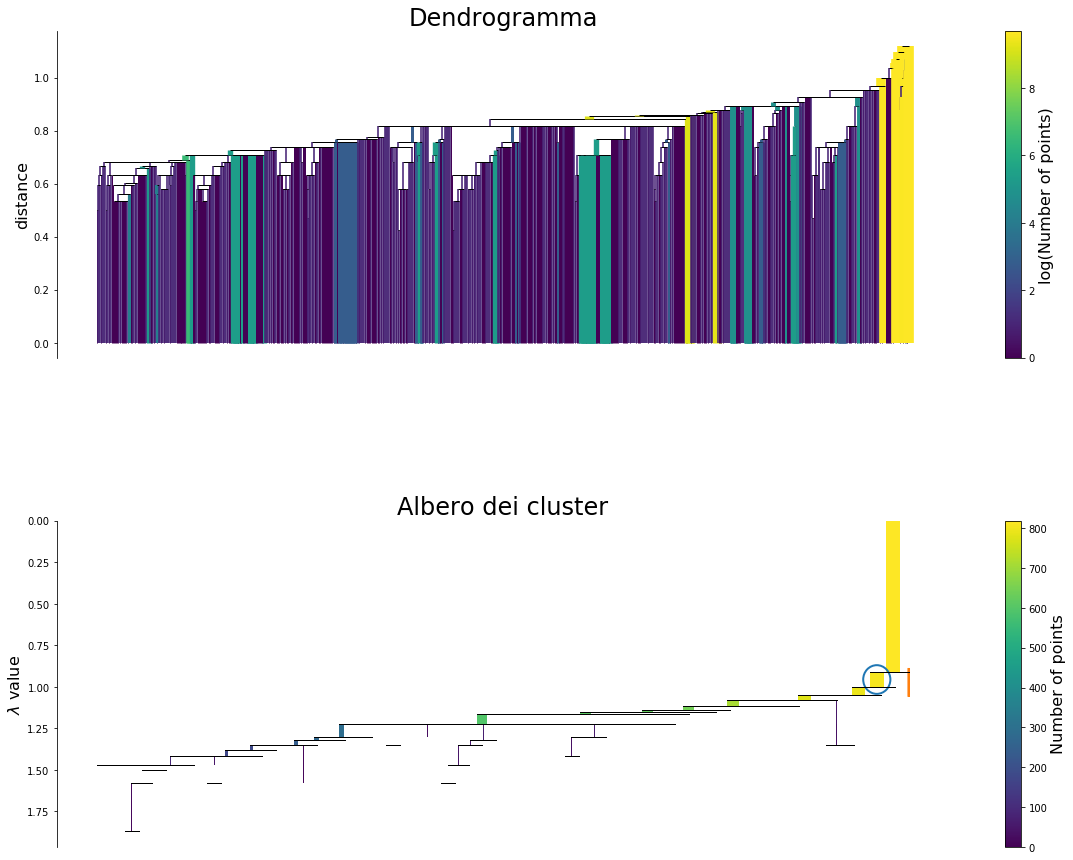

In [69]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='precomputed')
clusterer.fit_predict(n_matrix2)

plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['axes.labelsize'] = 16
fig = plt.figure()
fig.subplots_adjust(hspace=.5)

plt.subplot(2, 1, 1)
plt.gca().set_title('Dendrogramma', fontsize=24)
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

plt.subplot(2, 1, 2)
plt.gca().set_title('Albero dei cluster', fontsize=24)
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette());

<font size=3>
    
Entrambi i grafici sono uno dei passi specificati nella [documentazione](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html#build-the-cluster-hierarchy) per valutare il numero giusto di cluster da selezionare. Il primo grafico è il dendrogramma e rappresenta il modo in cui tutte le osservazioni sono state agglomerate nei cluster; essendo un metodo gerarchico si parte da ogni singola osservazione distinta fino ad arrivare ad un unico grande cluster. Il grafico non è molto comprensibile anche perché le osservazioni sono raggruppate lentamente e quindi il grafico risulta più compatto di altre situazioni.
<br></br>

Il secondo grafico è come il precedente ma in modo più leggibile ed intuibile. Nel dendogramma l'asse delle ordinate rappresentava la distanza in corrispondenza della quale le osservazioni erano raggruppate in un cluster e il colore era definito dal logaritmo del numero di termini nel cluster. In questo secondo grafico sulle ordinate si ha il reciproco della distanza e la scala di colore conta il numero di osservazioni.
<br></br>

La clusterizzazione viene stilizzata al minimo, si visualizzano i cluster e non le singole osservazioni per facilitare la lettura. La largezza delle righe varia a seconda del numero di osservazioni contenute nel cluster. I cluster cerchiati sono quelli proposti dall'algoritmo, in questo caso se ne notano due mentre il terzo non è mostrato in quanto è quello indicato dall'etichetta $-1$, ovvero le osservazioni che non rientrano in nessun altro cluster. La scelta manuale è quella di tracciare una linea orizzontale sul dendgrogramma e da lì selezionare il numero di cluster. Questo procedimento l'algoritmo lo fa in automatico ma con un approccio diverso: per ogni cluster viene definito un valore $\lambda$ determinato dai singoli valori $\lambda_i$ dei termini all'interno di esso. Questo valore indica la "stabilità" del cluster; quando un cluster si unirà all'altro, se il valore del nuovo cluster è inferiore a quello dei cluster figli, allora la stabilità del cluster è inferiore e quindi saranno considerati migliori i cluster figli.
<br></br>

Nel grafico si può notare il perché ci siano dei problemi nel raggruppare le osservazioni: i cluster sono creati poco alla volta ma è come se le osservazioni raggruppate non siano così simili fra loro e dissimili dalle altre, avvalorando la tesi che si tratti di una struttura globulare dove è difficile individuare dei cluster. La stabilità massima si raggiunge solamente alla fine quando ormai si sono unite osservazioni anche molto diverse fra di loro.
<br></br>


<br></br>
### [2.3.4 Modello Word2vec](#2.3.4)

<font size=3>
    
Un'ulteriore alternativa per il raggruppamento è partire dalla base definendo una nuova similarità che verrà utilizzata per la clusterizzazione. I modelli <b>Word2vec</b> sono delle reti neurali addestrate su un corpus di frasi che restituiscono come output un vettore multidimensionale per ogni parola trovata nei testi. Parole simili fra loro avranno una rappresentazione vettoriale somigliante e se visualizzate in un ipotetico spazio $n$-dimensionale, risulteranno vicine.

<font size=3>
    
Con la funzione KeyedVectors è possibile caricare un modello già pre-addestrato. L'oggetto che verrà caricato è il modello vero e proprio, ma non potrà essere modificato come riportato nella [documentazione](https://radimrehurek.com/gensim/models/keyedvectors.html). Il vantaggio è che avendo meno funzionalità, il modello risulta più leggero e meno dispensioso in termini di RAM. Quando si parla di <i>Word2vec</i> ci possono essere due tipi di modelli:
* Modelli da addestrare: sono modelli creati da zero dove si definisce un corpus speficifo dal quale ricavare i vettori di parole. Hanno il vantaggio di essere legate al dominio di utilizzo e più precisi di un modello generale, però l'addestramento richiede molto tempo.
* Modelli già addestrati: sono modelli creati su corpus estreni che si adattano ai termini di altri progetti, come in questo caso. I modelli saranno meno precisi ma si ha il vantaggio di superare tutta la parte di creazione.

Il modello utilizzato è stato addestrato sugli articoli di Google News per un totale di oltre $3$ milioni di parole e frasi analizzate. Le fonti non sono proprio le stesse dell'argomento analizzato, però diverse notizie riguardano proprio il tema del cinema e dello spettacolo, quindi si può ritenere il modello sufficientemente inerente per le analisi. La stessa [documentazione](https://code.google.com/archive/p/word2vec/) riporta che il modello è stato creato mediante il metodo <b>skip-gram</b> che è più lento ma più preciso di <b>CBOW</b> soprattutto per i termini meno frequenti.
<br></br>

Il modello era stato distribuito nel $2013$ e attualmente la pagina di download riporta un file non esistente. La stessa documentazione riporta un link per accedere al gruppo di discussione del progetto. In una delle [domande](https://groups.google.com/forum/#!topic/word2vec-toolkit/na9DndXmJ7o) un utente si chiede dove sia possibile scaricare il modello completo. Nelle risposte è presente un indirizzo di [Google Drive](https://docs.google.com/uc?export=download&confirm=YOURCODEID&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM) da dove è possibile ottenere il modello.
<br></br>

Il modello deve essere estratto dall'archivio `.zip` e messo nella stessa directory utilizzata dal notebook. Il nome del file è specificato nella funzione di loading insieme al parametro `binary` in quanto si tratta di un file `.bin`.

In [2]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

<font size=3>
    
Per la libreria <b>WordNet</b> si era creata una funzione, `find_word`, con il compito di identificare i nomi e di determinare l'elemento Synset relativo, filtrando i termini troppo corti e quelli che non rispettavano alcuni criteri legati alle lettere maiuscole. Per questo nuovo modello è necessario creare la funzione `find_word2` che si differenzia dalla prima solamente per delle modifiche alla fine del codice. Nella funzione originale erano stati scartati i termini non riconosciuti dalla libreria, in questo caso il check sarà attuato richiamando il modello creato immettendo come unico parametro il termine corrente dell'iterazione. 
<br></br>

Nel caso in cui il modello riconosca la parola, essa sarà inserita nella lista di output, in caso negativo si verificherebbe un `KeyError` che sarà aggirato mediante l'utilizzo di un blocco `Try-Except` con cui si passerà direttamente all'iterazione successiva.

In [12]:
def find_word2(w_list, w_pattern, w_output, nouns_list):
    for i in tqdm(range(len(w_list))):
        for j in range(len(w_list[i])):
            
            # le parole e i tag sono in un'unica stringa, si separano
            temp_w = w_list[i][j].split(' ') 
            temp_p = w_pattern[i][j].split(' ')
            
            for k in range(len(temp_p)):
                if temp_p[k] == "NN":
                    out = cases(temp_w[k])
                    nouns_list.append(temp_w[k])
                    
                    # Si controlla che non si tratti di un nome di persona
                    if temp_w[k] != temp_w[k].lower():
                        if k < (len(temp_p) - 1):
                            if (temp_w[k-1] != temp_w[k-1].lower()) or (temp_w[k+1] != temp_w[k+1].lower()):
                                break
                        else:
                            if (temp_w[k-1] != temp_w[k-1].lower()):
                                break
                            
                    # Le uniche maiuscole accettate sono quelle iniziali e si controlla se il lemma è un nome
                    if out in ['NU', 'FU']:
                        temp_w[k] = temp_w[k].lower()
                        if (temp_w[k] not in w_output) and (len(temp_w[k]) > 2):
                            try:
                                model[temp_w[k]]
                                w_output.append(temp_w[k])
                            except KeyError:
                                pass
                        
    return(w_output)

<font size=3>
    
L'elemento in output sarà una lista senza termini duplicati e che definirà la grandezza della matrice di similarità.

In [13]:
word_accepted2 = []
nouns_list2 = []
word_no_spell2 = find_word2(w_pattern_gsp, t_pattern_gsp, w_output=word_accepted2, nouns_list=nouns_list2)

100%|███████████████████████████████████████████████████████████████████| 10113411/10113411 [02:57<00:00, 57098.42it/s]


<font size=3>
    
Il modello non compresso ha una dimensione di $3.5$GB e possiede un dizionario più ampio di quello su WordNet: la matrice di similarità creata in precedenza aveva $17621$ elementi, i termini identificati dal modello Word2vec sono $24308$.
<br></br>

Sempre cone dia_matrix si crea una matrice quadrata che per motivi di spazio sarà subito convertita in un array.

In [79]:
m = len(word_accepted2)
distances_w2v = dia_matrix((m , m)).toarray()

<font size=3>

Per calcolare la similarità fra due parole è necessario applicare al nome del modello creato la funzione `similarity` che prende in input due elementi, le due parole di cui si calcolerà la similarità. Come fatto per l'altra matrice di similarità non saranno generati tutti i valori ma solo quelli della matrice triangolare superiore.

In [83]:
cont = 0
for i in tqdm(range(len(word_accepted2))):
    j = i
    while j < len(word_accepted2):
        distances_w2v[i, j] = model.similarity(word_accepted2[i], word_accepted2[j])
        j = j + 1

100%|██████████████████████████████████████████████████████████████████████████| 24308/24308 [1:41:59<00:00,  3.97it/s]


<font size=3>
    
Il modello permette di calcolare le similarità molto più velocemente rispetto alla libreria WordNet: anche con un terzo in più delle parole, il tempo necessario per creare la matrice (array) è stato meno della metà. Il motivo per cui si ha questo miglioramento nella velocità è da ricercarsi nell'algoritmo utilizzato per calcolare la similarità: in WordNet le parole erano messe in un grafo da cui si calcolava la lunghezza pesata dei percorsi, in gensim il modello calcola semplicemente la [similarità coseno](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.WordEmbeddingsKeyedVectors.n_similarity).

In [2]:
#np.save('distances_w2v.npy', distances_w2v)

distances_w2v = np.load("distances_w2v.npy")

<font size=3>
    
Si riempie la matrice triangolare inferiore con i valori specchiati di quelli calcolati.

In [6]:
for i in tqdm(range(distances_w2v.shape[0])):
    for j in range(distances_w2v.shape[1]):
        if j < i:
            distances_w2v[i, j] = distances_w2v[j, i]

100%|███████████████████████████████████████████████████████████████████████████| 24308/24308 [02:09<00:00, 187.14it/s]


<font size=3>
    
Per definizione l'intervallo di valori che può assumere la similarità coseno è $[1,-1]$, dove il massimo indica elementi uguali mentre il minimo oggetti completamente opposti. È quindi ancora possibile effettuare una sottrazione rispetto a uno in quanto non ci saranno valori negativi. Con il seguente codice si cercherà di identificare sia se esistano termini con una similarità pari a uno e che quindi possano costituire un nuovo insieme di sinonimi, sia il valore minimo in tutta la matrice.

In [10]:
np.fill_diagonal(distances_w2v, 0)
print("Massimo valore di similarità: " + str(distances_w2v.max()))
print("Minor valore di similarità: " + str(distances_w2v.min()))
np.fill_diagonal(distances_w2v, 1)

Massimo valore di similarità: 0.968
Minor valore di similarità: -0.311


In [12]:
d_matrix_w2v = np.matrix(distances_w2v)
d_matrix_w2v = 1 - (d_matrix_w2v)

<font size=3>
    
La funzione clustering non deve essere modicata, l'unico elemento che cambia è il tipo di linkage: viste le scarse prestazione del metodo <i>single</i>, in queste analisi non sarà utilizzato.

In [18]:
link = ['average', 'complete']
silhouette_score_w2v, CH_score_w2v = [[] for i in range(2)]
(silhouette_w2v, CH_w2v) = clustering(10, 51, link_list=link, dist=d_matrix_w2v, 
                              silhouette_score=silhouette_score_w2v, CH_score=CH_score_w2v)

<font size=3>
    
Si può chiamare la funzione `h_plot_evaluation` per un confronto grafico in quanto ci sono solo due liste da visualizzare.

In [19]:
c = [i for i in range(10, 51)]
h_plot_evaluation(title="Word2vec Silhouette index", metric=silhouette_w2v[0], c=c, label1="Average",
                  metric2=silhouette_w2v[1], label2="Complete", pos_legend="top_right")

<font size=3>
    
I valori sono peggiori di entrambi i modelli provati in precedenza, l'andamento è simile a quello visto in precedenza dove i modelli premiati sono quelli con pochi cluster. Anche se le differenze sembrano evidenti sul grafico, i valori sull'asse delle ordinate sottolineano come per tutti i modelli la bontà di clusterizzazione sia molto simile.

In [20]:
h_plot_evaluation(title="Word2vec Calinski-Harabasz score", metric=CH_w2v[0], c=c, label1="Average",
                  metric2=CH_w2v[1], label2="Complete", pos_legend="top_right")

<font size=3>
    
Per lo score di <i>Calinski-Harabasz</i> i modelli hanno un andamento molto più chiaro, decrescente al crescere dei cluster. 

<font size=3>

Si prova a modificare il set di parole utilizzando quello creato in precedenza con la rimozione dei sinonimi. Una delle differenze fra il modello WordNet e Word2vec è che il primo effettuava un pre-processing della parola data in input, quindi non era case sensitive a differenza del secondo dove la stessa parola scritta con la prima lettera maiuscola e tutta minuscola esistevano due rappresentazioni vettoriali differenti. 
<br></br>

Dal dizionario delle similarità si devono quindi estrarre le chiavi e trasformarle tutte in minuscolo e si crea un nuovo dizionario facendo corrispondere a queste nuove chiavi i vecchi valori. Un dizionario di base non permette di accedere ai suoi valori in modo ordinato, proprio per la natura stessa dell'oggetto in Python. Dalle versioni 3.x di Python è quindi necessario [trasformare i valori in una lista](https://stackoverflow.com/questions/4326658/how-to-index-into-a-dictionary) prima di poter accedere agli elementi tramite un indice. 

In [41]:
keys_lower = [word.lower() for word in diz_similarity.keys()]
diz_similarity2 = {}
for i in range(len(keys_lower)):
    diz_similarity2[keys_lower[i]] = list(diz_similarity.values())[i]

<font size=3>
    
Come già fatto diverse volte in precedenza in corrispondenza degli elementi non trovati nel dizionario viene posto un elemento nullo, preservare l'ordine delle parole serve per rimuovere correttamente gli elementi dalla matrice.

In [42]:
new_w2v_words = []
filter_w2v = []
for word in word_accepted2:
    if (word in diz_similarity2.keys()) and (word not in filter_w2v):
        new_w2v_words.append(word)
        for w in diz_similarity2[word]:
            filter_w2v.append(w)
    else:
        new_w2v_words.append('')

<font size=3>
    
La lista `w2v_words` contiene solo le parole che non sono state rimosse.

In [45]:
idx_w2v = [i for i, x in enumerate(new_w2v_words) if x == '']
idx_w2v.reverse()

n_matrix_w2v = np.delete(d_matrix_w2v, (idx_w2v), axis=0)
n_matrix_w2v = np.delete(n_matrix_w2v, (idx_w2v), axis=1)

w2v_words = [word for word in new_w2v_words if word != '']

C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """


<font size=3>
    
La lunghezza della nuova lista è diversa da quello del modello precedente nonostante si siano gestiti i casi di parole con la prima lettera maiuscola. Una delle possibili spiegazioni è che il modello Word2vec non riconosce alcune parole del modello WordNet e viceversa, questo fa sì che dei termini diversi sono stati filtrati nella funzione `find_word2`.

In [46]:
n_matrix_w2v.shape

(12970, 12970)

<font size=3>
    
Si replicano i modelli con la nuova matrice.

In [47]:
link = ['average', 'complete']
silhouette_score_w2v2, CH_score_w2v2 = [[] for i in range(2)]
(silhouette_w2v2, CH_w2v2) = clustering(10, 51, link_list=link, dist=n_matrix_w2v, 
                                        silhouette_score=silhouette_score_w2v2, CH_score=CH_score_w2v2)

In [48]:
h_plot_evaluation(title="Word2vec filter Silhouette index", metric=silhouette_w2v2[0], c=c, label1="Average",
                  metric2=silhouette_w2v2[1], label2="Complete", pos_legend="top_right")

<font size=3>
    
I risuiltati non sono a livello dei migliori modelli, il range di valori è molto contenuto fra $[0.01,-0.02]$, non c'è una chiara distizione fra i due metodi.

In [49]:
h_plot_evaluation(title="Word2vec filter Calinski-Harabasz score", metric=CH_w2v2[0], c=c, label1="Average",
                  metric2=CH_w2v2[1], label2="Complete", pos_legend="top_right")

<font size=3>
    
Come prima l'indice è descrescente in modo pressoché costante.

<font size=3>
    
Gli ultimi modelli saranno creati partendo dalla lista di parole più comuni.

In [50]:
common_words2 = Counter(nouns_list2).most_common()
common_words2[0:10]

[('movie', 577963),
 ('film', 442949),
 ('story', 197627),
 ('time', 112183),
 ('character', 86501),
 ('way', 75376),
 ('plot', 73817),
 ('thing', 63447),
 ('life', 61876),
 ('scene', 52757)]

<font size=3>
    
Partendo dalla nuova lista delle mille parole più comuni, si controlla se ogni termine ha dei sinonimi identificati dal modello WordNet, in caso affermativo come valore del dizionario viene inserita una lista con tutti i sinonimi. In un'altra lista sono inserite tutte le parole più frequenti eccetto i sinonimi identificati.

In [51]:
new_w2v_words2 = []
filter_w2v2 = []
for word in common_words2[0:1000]:
    if word[0] in diz_similarity.keys():
        for w in diz_similarity[word[0]]:
            filter_w2v2.append(w)

    if word[0] not in filter_w2v2:
        new_w2v_words2.append(word[0])
    else:
        new_w2v_words2.append('')

<font size=3>
    
Rimuovendo dalla matrice le righe e le colonne corrispondenti alle parole considerate sinonimi e per quelle non nella lista delle mille più frequenti, si ottiene una nuova matrice di dimensioni $835$.

In [52]:
idx_w2v2 = [w2v_words.index(word) for word in w2v_words if word not in new_w2v_words2]
idx_w2v2.reverse()

n_matrix_w2v2 = np.delete(n_matrix_w2v, (idx_w2v2), axis=0)
n_matrix_w2v2 = np.delete(n_matrix_w2v2, (idx_w2v2), axis=1)

C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """


In [53]:
n_matrix_w2v2.shape

(835, 835)

<font size=3>
    
Si procede con la creazione di modelli con la nuova matrice delle distanze.

In [54]:
silhouette_score_w2v3, CH_score_w2v3 = [[] for i in range(2)]
(silhouette_w2v3, CH_w2v3) = clustering(10, 51, link_list=link, dist=n_matrix_w2v2, 
                                        silhouette_score=silhouette_score_w2v3, CH_score=CH_score_w2v3)

In [55]:
h_plot_evaluation(title="Word2vec filter Silhouette index", metric=silhouette_w2v3[0], c=c, label1="Average",
                  metric2=silhouette_w2v3[1], label2="Complete", pos_legend="top_left")

<font size=3>
    
A differenza del metodo WordNet dove non si era riscontrato un miglioramento delle performance di clusterizzazione, in questo caso i nuovi modelli ottengono una clusterizzazione più accettabile ma sempre lontano dai livelli dei migliori. L'indice cresce al crescere del numero di cluster.

In [56]:
h_plot_evaluation(title="Word2vec filter Calinski-Harabasz score", metric=CH_w2v3[0], c=c, label1="Average",
                  metric2=CH_w2v3[1], label2="Complete", pos_legend="top_right")

<font size=3>
    
Spesso l'indice di <i>Calinski-Harabasz</i> e quello di <i>Silhouette</i> hanno avuto comportamenti opposti e in questo caso il trend viene confermato: per un maggiore numero di cluster la metrica assume valori peggiori, più bassi, mentre l'ottimale di ha con il numero minimo di cluster selezionati. L'andamento è uguale a quello dei modelli con la matrice di medie dimensioni, descrescente al creascere del numero di cluster, e qua non si ha una netta divisione fra i due metodi di linkage, le due curve si intersecano frequentemente.

<br></br>
### [2.3.5 Lemmatizzazione](#2.3.5)

<font size=3>
    
Durante l'identificazione della parola da parte del modello, nel caso di Word2vec non viene applicata alcuna funzione di pre-processing in quanto il modello caricato contiene le informazioni di testi reali che non hanno subito trasformazioni. Un'alternativa potrebbe essere creare una lemmatizzazione per ridurre la dimensionalità della matrice e sperare in una migliore classificazione.
<br></br>

La funzione si base su `find_word2`, in cui nell'ultimo passaggio viene aggiunta la lemmatizzazione realizzata tramite la funzione `lemmatize` della libreria `ntkl`. La funzione di lemmatizzazione è inserita nella classe `WordNetLemmatizer` che sarà assengata all'oggetto `lemmatizer` e che tramite quest'ultimo sarà richiamata.

In [57]:
def find_word3(w_list, w_pattern, w_output, nouns_list):
    for i in tqdm(range(len(w_list))):
        for j in range(len(w_list[i])):
            
            # le parole e i tag sono in un'unica stringa, si separano
            temp_w = w_list[i][j].split(' ') 
            temp_p = w_pattern[i][j].split(' ')
            
            for k in range(len(temp_p)):
                if temp_p[k] == "NN":
                    out = cases(temp_w[k])
                    nouns_list.append(temp_w[k])
                    
                    # Si controlla che non si tratti di un nome di persona
                    if temp_w[k] != temp_w[k].lower():
                        if k < (len(temp_p) - 1):
                            if (temp_w[k-1] != temp_w[k-1].lower()) or (temp_w[k+1] != temp_w[k+1].lower()):
                                break
                        else:
                            if (temp_w[k-1] != temp_w[k-1].lower()):
                                break
                            
                    # Le uniche maiuscole accettate sono quelle iniziali e si controlla se il lemma è un nome
                    if out in ['NU', 'FU']:
                        temp_w[k] = lemmatizer.lemmatize(temp_w[k].lower(), pos ="n")
                        if (temp_w[k] not in w_output) and (len(temp_w[k]) > 2):
                            try:
                                model[temp_w[k]]
                                w_output.append(temp_w[k])
                            except KeyError:
                                pass
                        
    return(w_output)

In [58]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

<font size=3>
    
L'obiettivo della lemmatizzazione è quello di trovare un set di parole più ridotto e basilare per semplificare il compito di clusterizzazione.

In [ ]:
word_accepted_lem = []
nouns_list_lem = []
word_no_spell_lem = find_word3(w_pattern_gsp, t_pattern_gsp, w_output=word_accepted_lem, nouns_list=nouns_list_lem)

In [60]:
len(word_accepted_lem)

29169

<font size=3>
    
Non si sono registrati grandi miglioramenti, la numerosità della lista trovata è solo di qualche centinaia di termini più corta e non dovrebbero esserci modifiche sostanziali alle operazioni di clusterizzazione.

<br></br>
### [2.3.6 Alternative](#2.3.6)

<font size=3>
    
Le clusterizzazioni non sono buone per una combinazione di fattori:
* L'<i>indice di Silhouette</i> raggiunge al massimo $0.25$ nel primo modello WordNet senza filtraggio di parole, con un numero di cluster pari a $12$. Tutte le altre combinazioni non offrono un valore migliore e anzi in alcuni casi sono nettamente inferiori.
* Il numero di osservazioni spesso non è in sintonia con il numero di cluster identificati il che porta, come confermato dal metodo HDBSCAN ad un cluster enorme con dentro la maggior parte delle osservazioni, rendendo il raggruppamento non efficace.
* Provare a cambiare metrica per la matrice delle distanze o ad utilizzare metodi alternativi come Word2vec non ha portatato a delle migliorie.

Anche se non ha avuto grande successo nella clusterizzazione, il modello Word2vec possiede un'interessante funzione, `most_similar`, che permette di visualizzare un numero predifinito di parole considerate le più simili a quella data.

In [3]:
a = model.most_similar('cinema', topn=10)
for word in a:
    print(word)

('cinemas', 0.6968410015106201)
('Cinema', 0.6812143921852112)
('film', 0.6696188449859619)
('arthouse_cinema', 0.6569762229919434)
('films', 0.653031051158905)
('theater', 0.6515337824821472)
('arthouse', 0.6391520500183105)
('arthouse_cinemas', 0.6353806257247925)
('movie', 0.6317482590675354)
('filmmaking', 0.6315000057220459)


<font size=3>
    
Le similarità sono le stesse riportate nella matrice delle distanze, però con un atteggiamento meno rigoroso si potrebbe pensare che se una parola compare nei primi dieci risultati più simili di un'altra parola, la si potrebbe considerare un suo sinonimo e un candidato per essere raggruppato assieme.

In [14]:
diz_most_similar = {}
for word in tqdm(range(len(word_accepted2))):
    similar_list = []
    temp = model.most_similar(word_accepted2[word], topn=10)
    for i in range(len(temp)):
        if temp[i][0] in word_accepted2:
            similar_list.append(temp[i][0])
            
    diz_most_similar[word_accepted2[word]] = similar_list

  1%|▌                                                                           | 215/29379 [00:37<1:26:48,  5.60it/s]

KeyboardInterrupt: 

In [24]:
diz_most_similar['cinema']

['film', 'theater', 'arthouse', 'movie', 'filmmaking']

In [25]:
with open('diz_most_similar', 'wb') as fp:
    pickle.dump(diz_most_similar, fp)

<br></br>
### [2.3.7 Wu-Palmer no root](#2.3.7)

In [70]:
m = len(word_accepted)
distances_nr = dia_matrix((m , m)).toarray()

In [71]:
from nltk.corpus import wordnet as wn
cont = 0
for i in tqdm(range(len(word_accepted_list))):
    j = i
    while j < len(word_accepted_list2):
        distances_nr[i, j] = round(wn.wup_similarity(word_accepted_list[i], word_accepted_list2[j], simulate_root=False),3)
        j = j + 1

100%|██████████████████████████████████████████████████████████████████████████| 20187/20187 [5:09:54<00:00,  1.09it/s]


In [73]:
np.save('distances_nr.npy', distances_nr)

In [6]:
#np.save('distances_nr.npy', distances_nr)

distances_nr = np.load("distances_nr.npy")

In [78]:
diz_similarity = {}
for i in tqdm(range(distances_nr.shape[0])):
    target = words[i]
    sim = []
    for j in range(distances_nr.shape[1]):
        if distances_nr[i, j] == 1 and (i != j):
            sim.append(words[j])
            
    diz_similarity[target] = sim

100%|███████████████████████████████████████████████████████████████████████████| 20187/20187 [02:33<00:00, 131.20it/s]


In [85]:
primary_words = []
filter_words = []
for word in diz_similarity.keys():
    if (word not in primary_words) and (word not in filter_words):
        primary_words.append(word)
    else:
        primary_words.append('')
    
    for w in diz_similarity[word]:
        filter_words.append(w)

In [86]:
removed = sum([1 for word in primary_words if word == ''])
print(removed)
removed == len(set(filter_words))

4159


True

In [87]:
idx = [i for i, x in enumerate(primary_words) if x == '']
idx.reverse()

distances_nr = np.delete(distances_nr, (idx), axis=0)
distances_nr = np.delete(distances_nr, (idx), axis=1)

for i in idx:
    del primary_words[i]

In [88]:
for i in tqdm(range(distances_nr.shape[0])):
    for j in range(distances_nr.shape[1]):
        if j < i:
            distances_nr[i, j] = distances_nr[j, i]

100%|███████████████████████████████████████████████████████████████████████████| 16028/16028 [01:03<00:00, 252.58it/s]


In [89]:
d_matrix = np.matrix(distances_nr)
d_matrix1 = 1 - d_matrix

In [90]:
link = ['single', 'average', 'complete']
silhouette_score, CH_score = [[] for i in range(2)]
(silhouette, CH) = clustering(10, 41, link_list=link, dist=d_matrix1, 
                              silhouette_score=silhouette_score, CH_score=CH_score)

In [91]:
d_matrix2 = np.sqrt(2 * (1 - d_matrix))

silhouette_score2, CH_score2 = [[] for i in range(2)]
(silhouette2, CH2) = clustering(10, 41, link_list=link, dist=d_matrix2,
                                silhouette_score=silhouette_score2, CH_score=CH_score2)

In [92]:
c = [i for i in range(10, 41)]
plot_evaluation(title="Silhouette index \n1-sim", metric=silhouette, pos_legend='center_right', c=c,
                title2="Silhouette index \ncosine_sim", metric2=silhouette2, pos_legend2='center_right')

In [94]:
with open('nouns_list', "rb") as input_file:
    noun_list = pickle.load(input_file)

In [95]:
common_words = Counter(noun_list).most_common()
primary_words2 = []
filter_words2 = []
for word in common_words[0:1000]:
    if word[0] in diz_similarity.keys():
        for w in diz_similarity[word[0]]:
            filter_words2.append(w)

    if word[0] not in filter_words2:
        primary_words2.append(word[0])
    else:
        primary_words2.append('')

In [96]:
idx2 = [primary_words.index(word) for word in primary_words if word not in primary_words2]
idx2.reverse()

n_matrix = np.delete(distances, (idx2), axis=0)
n_matrix = np.delete(n_matrix, (idx2), axis=1)

for i in idx2:
    del primary_words[i]

C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """


In [97]:
n_matrix.shape

(819, 819)

In [98]:
n_matrix = np.matrix(n_matrix)
n_matrix1 = 1 - n_matrix

# complementare
silhouette_score3, CH_score3 = [[] for i in range(2)]
(silhouette3, CH3) = clustering(2, 31, link_list=link, dist=n_matrix1, 
                                silhouette_score=silhouette_score3, CH_score=CH_score3)

# cosine similarity
n_matrix2 = np.sqrt(2 * (1 - n_matrix))

silhouette_score4, CH_score4 = [[] for i in range(2)]
(silhouette4, CH4) = clustering(2, 31, link_list=link, dist=n_matrix2, 
                                silhouette_score=silhouette_score4, CH_score=CH_score4)

In [99]:
c = [i for i in range(2, 31)]
plot_evaluation(title="Silhouette index \n1-sim", metric=silhouette3, pos_legend='center_right', c=c,
                title2="Silhouette index \ncosine_sim", metric2=silhouette4, pos_legend2='center_right',)

In [104]:
model = AgglomerativeClustering(affinity='precomputed', n_clusters=12, linkage="average").fit(n_matrix1)
labels = model.labels_
Counter(labels).most_common()

[(3, 211),
 (5, 147),
 (1, 140),
 (0, 80),
 (8, 76),
 (4, 47),
 (7, 38),
 (6, 36),
 (2, 19),
 (10, 13),
 (9, 11),
 (11, 1)]

In [105]:
temp = pd.DataFrame({'Word': primary_words, 'Cluster': labels})

temp["Freq"] = temp["Word"].map(dict(common_words))
temp = temp.sort_values(by='Freq', ascending=False)

temp.head()
temp.to_csv(path_or_buf="D:/Scraping/labels_noroot.csv", index=False)

In [101]:
with open('diz_similarity', 'wb') as fp:
    pickle.dump(diz_similarity, fp)
    
"""
with open('nouns_list', 'wb') as fp:
    pickle.dump(nouns_list, fp)
"""

"\nwith open('nouns_list', 'wb') as fp:\n    pickle.dump(nouns_list, fp)\n"